#  $\color{olive}{\textbf{Jupyter notebook bij Hoofdstukken 3 en 4 van Kwantummechanica 1}}$

Deze Jupyter notebook lost de eendimensionale Schrodingervergelijking numeriek op via een techniek die uitstekend wordt in uitgelegd in
https://medium.com/@natsunoyuki/quantum-mechanics-with-python-de2a7f8edd1f en https://ben.land/post/2022/03/09/quantum-mechanics-simulation/.

Sommige van de onderstaande functies zijn gebaseerd op het eerste werk (en bijbehorende Github) maar werden sterk uitgebreid en veralgemeend.

Basis van de techniek om de eendimensionale Schrodinger vergelijking numeriek op te lossen:


1.   TISE is een eigenwaardevergelijking:
2.   Introduceer golffunctie $\psi (x)$ en potentiaal $V(x)$ in aantal discrete punten: $ \frac{(-1)}{\left(\Delta x \right)^2 } \left[ \psi _{n+1} -2  \psi _n + \psi _{n-1} \right] + \frac{2m}{\hbar ^2}V_n \psi_n = \frac{2m}{\hbar ^2} E \psi_n\; ; \; V (x_0 + n \Delta x) \equiv V_n \; ; \; \psi (x _0 + n \Delta x) = \psi _n $
3. Via Taylor ontwikkeling is het eenvoudig aan te tonen dat: $ \frac{d^2}{d x^2} \psi (x_0 + n \Delta x)  \approx \frac{1}{\left(\Delta x \right)^2 } \left[ \psi _{n+1} -2  \psi _n + \psi _{n-1} \right] $
4. De gediscretiseerde TISE wordt dan: $ \frac{(-1)}{\left(\Delta x \right)^2 } \left[ \psi _{n+1} -2  \psi _n + \psi _{n-1} \right] + \frac{2m}{\hbar ^2}V_n \psi_n = \frac{2m}{\hbar ^2} E \psi_n $
5. De Hamiltoniaan-matrix wordt dus een tri-diagonale matrix met $ \left( \frac{2}{\left(\Delta x \right)^2} + \frac{2m}{\hbar ^2}V_n \right)$  op de hoofddiagonaal, en $\frac{-1}{\left(\Delta x \right)^2}$ op de diagonalen boven en onder de hoofddiagonaal. Dergelijke matrices die vooral uit nullen bestaan noemt men "sparse matrices" https://en.wikipedia.org/wiki/Sparse_matrix ("ijle matrices" in het Nederlands). Eigenwaardevergelijkingen met "sparse matrices" kunnen zeer snel numeriek opgelost worden.  Er zijn speciale technieken om "sparse matrices" op te slaan en te construeren.
6. In de onderstaande voorbeelden wordt de volgende methodologie gebruikt: (i) er wordt een dimensieloze positie-coordinaat geintroduceerd $\xi = \alpha x$ ($\alpha$ heeft als dimensie $\frac{1}{L})$; (ii) er wordt een goed gekozen eenheid van energie ($=V_0$) geintroduceerd; (iii) de TISE kan dan herschreven worden als $ \left[ - \frac {d^2} {d \xi ^2} + V(\xi) \right] \psi  (\xi) = \lambda ^2 \frac{E} {V_0} \psi  (\xi) \; , $ met $\lambda ^2 $ een goed gekozen dimensieloze grootheid en $V(\xi)$ de potentiaal in dimensieloze grootheden.  Bovenstaande TISE neemt de volgende gediscretiseerde vorm aan: $ \frac{(-1)}{\left(\Delta \xi \right)^2 } \left[ \psi _{n+1} -2  \psi _n + \psi _{n-1} \right] + V_n (\xi) \psi_n = \left( \lambda ^2 \frac {E} {V_0} \right) \psi_n \; $, met  $\psi (\xi _0 + n \Delta \xi) = \psi _n $. Na oplossing van de gediscretiseerde TISE bekomt men de golffuncties $\psi _{\gamma} (\xi)$ bij de energie-eigenwaarden $\epsilon_{\gamma} = \left( \lambda ^2 \frac {E_{\gamma}} {V_0} \right)$.  


De onderstaande notebook lost de eendimensionale Schrodingervergelijking op voor de volgende situaties:


1.   De lineair harmonische oscillator
2.   De zogenaamde ``bounded harmonic oscillator''
3.   De Morse potentiaal
4.   De zogenaamde "Mexican hat" (of, Sombrero) potentiaal
5.   Een "Mystery potential"
6.   De eendimensionale Lennard-Jones potentiaal
7.   De linearie potentiaal (met toepassingen in gravitatie)

Uit deze voorbeelden wordt duidelijk hoe numerieke kwantummechanica gebruik maakt van dimensieloze grootheden (voor de posities en de energie). De voorbeelden illustreren ook het oscillatietheorema en het feit dat symmetrische potentialen golffuncties met een goede pariteit opleveren.

Graag suggesties.

Auteur: Jan Ryckebusch, November-December 2024





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as sla

# tweak the parameters of the plots: makes things look nicer ...
params = {'legend.fontsize' : 20,
          'axes.linewidth'  : 2.5,
          'axes.labelsize'  : 20,
          'lines.linewidth' : 2,
          'xtick.major.width' : 3,
          'xtick.major.size'  : 12,
          'ytick.major.width' : 3,
          'ytick.major.size'  : 12,
          'xtick.major.pad'  : 10,
          'xtick.minor.width' : 2,
          'xtick.minor.size'  : 6,
          'ytick.minor.width' : 2,
          'ytick.minor.size'  : 6,
          'xtick.labelsize'    : 18,
          'ytick.labelsize'    : 18 }
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts} \boldmath"]
plt.rcParams.update(params)
plt.rc("font",family="serif",weight='bold')

Twee basisfuncties:

1. **schrodinger1D** berekent de energie-eigenwaarden en energie-eigenfuncties voor een gegeven potentiaal.

2. **eval_wavefunctions** maakt op basis van de resultaten van **schrodinger1D** de figuren en berekent ook bepaalde grootheden (verwachtingswaarde van potentiele en de kinetische energie in de stationaire toestanden)

In [2]:
def schrodinger1D(xmin, xmax, Nx, WatPot, params, neigs, findpsi=False):
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size
    # Obtain the potential function values:
    if WatPot == 1:
      V = params[0] * x**2 # HO potentiaal
    if WatPot == 2:
      aa2= params[1]*params[1]
      V = -2. * params[0] * aa2 /(aa2+ np.square(x)) # BHO potentiaal
    if WatPot == 3:
      V = params[0] * np.square(1 - np.exp(-x)) # Morse potentiaal params[0]=\lambda ^2
    if WatPot == 4:
      V = params[0] + params[1] * (np.power(x,4.)-2.*np.power(x,2.)) # Sombrero potentiaal
    if WatPot == 5:
      V = params[0] + 1. - np.divide(2.,x)   # Mystery potentiaal
    if WatPot == 6:
      V = params[0] * (np.power(x,-12.) - 2.*np.power(x,-6.))   # Lennard Jones potentiaal
    if WatPot == 7:
      V = np.abs(x)  # linear potentiaal
    # create the Hamiltonian Operator matrix:
    # start with a Nx \times Nx matrix with 2 on the diagonal; other elements are zero
    H = sparse.eye(Nx, Nx, format='lil') * 2  # "List of List" format for Sparse Matrices
    # implement the off-diagonal elements of the second-order numerical derivative in het Hamiltonian Operator matrix
    for i in range(Nx - 1):
        H[i, i + 1] = -1
        H[i + 1, i] = -1
    H = H / (dx ** 2)
    # Add in the potential energy V (xi) (xi is a dimension-less position coordinate)
    for i in range(Nx):
        H[i, i] = H[i, i] + V[i]
    # convert to csc sparse matrix format:
    H = H.tocsc()
    # obtain neigs solutions from the sparse matrix:
    [evl, evt] = sla.eigs(H, k=neigs, which='SM')
    for i in range(neigs):
        # normalize the eigenvectors:
        evt[:, i] = evt[:, i] / np.sqrt(
                                np.trapz(np.conj(
                                evt[:,i])*evt[:,i],x))
        # eigen values MUST be real:
        evl = np.real(evl)
    if findpsi == False:
        return evl
    else:
        return evl, evt, x, V # eigenvalues, eigenvectors, x-values, potential

In [3]:
def eval_wavefunctions(xmin, xmax, Nx, WatPot, params, neigs, findpsi, EndEner,ScalWav):
  """
  The function eval_wavefunctions
  (1) calls schrodinger1D to solve the given eigenvalue problem,
  (2) calculates the probability of the particle existing at some particular grid point from the wave functions,
  (3) plots the probability density functions for the neighs eigenfunctions;
  (4) it prints the eigenvalues sorted in ascending magnitude;
  (5) Figure is made of the expectation values of the kinetic and potential energy (for energy eigenvalues up to EndEner);
  (6) Figure is made of the bound-state wave functions in the potential

  Args:
    xmin: lowest x value with a non-negligible value for wavefunction
    xmax: highest x value with a non-negligible value for wavefunction
    Nx: number of grid points
    WatPot: type of potential (1:1D-HO; 2: 1D-BHO; 3: 1D-Morse; 4: Sombrero; 5: Mystery potential; 6: Lennard-Jones; 7: linear potential)
    params: parameters that determine the potential
    neigs: required number of energy eigenvalues
    EndEner: maximum energy for the energy eigenvalues for which the results are plotted
    ScalWav: scaling factor for wavefunctions in the plot with the potential (to make things look better ...)
  """

  H = schrodinger1D(xmin, xmax, Nx, WatPot, params, neigs, findpsi) # call 1D Schrodinger solver (H[0] eigenvalues, H[1] eigenvectors, H[2] x-values, H[3] potential)
  evl = H[0] # energy eigenvalues
  indices = np.argsort(evl) # sort the eigenvalues
  print("Energy eigenvalues (for units consult the explanations for the different potentials):")
  for i,j in enumerate(evl[indices]):
    print("{:>3}: {:.4f}".format(i+1,j)+" "*3,end="",flush=True)
    if (i+1) % 8 == 0: print() # eight numbers per line
  print()

  evt = H[1] # eigenvectors
  xi2 = np.zeros(neigs,dtype='float')
  dxi2= np.zeros(neigs,dtype='float')
  values_of_n=np.arange(0,neigs,1)
  xisquar=np.power(H[2],2.) # array of xi**2 values
  delta_xi=H[2][1]-H[2][0] # grid spacing

  plt.figure(figsize=(8,12)) # figuur met de gekwadrateerde energie-eigenfuncties (gesorteerd = evl[indices])
  for i in range(neigs):
    n = indices[neigs-i-1] # from high to low energy
    y = np.real(np.conj(evt[:, n]) * evt[:, n]) # P(x)=\psi ^{*}( \xi) \psi(\xi)
    dyy=np.real(np.multiply(np.conj(evt[:, n]), np.gradient(np.gradient(evt[:, n],H[2]),H[2]))) # second-order derivative ...
    xi2[n]=np.trapz(np.multiply(H[3],y),H[2]) # <V(x)>
    dxi2[n]=-np.trapz(dyy,H[2]) # < - \partial ^2 / \partial xi**2>
    plt.subplot(neigs, 1, i+1)  # neigs subplots without axes ...
    plt.subplots_adjust()
    plt.axis('off')
    plt.plot(H[2],y,color='CornflowerBlue')
    plt.text(1.05*xmax,0.,'$n$={0}'.format(str(n)),color='CornflowerBlue')
  plt.show()


  # Figuur figpn: Links: verwachtingswaarde van V(\xi) versus energie-eigenwaarden (gesorteerd = evl[indices])
  #               Rechts: verwachtingswaarde van - \partial ^2 / \partial xi**2 versus energie-eigenwaarde (tot EndEner)
  # 1D-HO: nagaan of het numeriek resultaat voldoet aan het gekend analytisch resultaat
  figpn = plt.figure(figsize=(18,7),constrained_layout=True) # constrained_layout adjusts subplots so that tick labels, legends, colorbars, ...  do not overlap,
  axpn  = figpn.add_subplot(121)
  axpp  = figpn.add_subplot(122)

  axpn.set_xlim(evl[indices][0]-0.2, EndEner+0.2) # solely energy-eigenvalues <= EndEner
  xi2_displayed = xi2[(evl[indices]<EndEner)] # masking ...
  h = np.abs(np.max(xi2_displayed) - np.min(xi2_displayed))
  bot = np.min(xi2_displayed)-0.05*h
  top = np.max(xi2_displayed)+0.05*h
  axpn.set_ylim(bot,top) # proper determination of bottom and top via preceding four lines ...

  axpn.set_ylabel(r"Verwachtingswaarde $\bf \left< V(\xi) \right> $",fontsize=21,weight='bold')
  if WatPot <= 2: # 1D-HO of 1D-BHO
    axpn.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {\hbar \omega}{2} \right]$",fontsize=21,weight='bold')
    axpp.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {\hbar \omega}{2} \right]$",fontsize=21,weight='bold')
  if WatPot == 3: # 1D-Morse
    axpn.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {D_e}{\lambda ^2} \right]$",fontsize=21,weight='bold')
    axpp.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {D_e}{\lambda ^2} \right]$",fontsize=21,weight='bold')
  if WatPot == 4: # 1D-Mexican hat
    axpn.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {V_0}{\kappa ^2} \right]$",fontsize=21,weight='bold')
    axpp.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {V_0}{\kappa ^2} \right]$",fontsize=21,weight='bold')
  if WatPot == 5: # Mystery potential
    axpn.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {C}{\lambda ^2} \right]$",fontsize=21,weight='bold')
    axpp.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {C}{\lambda ^2} \right]$",fontsize=21,weight='bold')
  if WatPot == 6: # Lennard-Jonew potential
    axpn.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {\epsilon}{\lambda ^2} \right]$",fontsize=21,weight='bold')
    axpp.set_xlabel(r"Energie-eigenwaarde $\bf \left[ \frac {\epsilon}{\lambda ^2} \right]$",fontsize=21,weight='bold')
  if WatPot == 7: # Linear potential
    axpn.set_xlabel(r"Energie-eigenwaarde $\bf \left[ b \alpha \right]$",fontsize=21,weight='bold')
    axpp.set_xlabel(r"Energie-eigenwaarde $\bf \left[ b \alpha \right]$",fontsize=21,weight='bold')


  axpn.set_title(r"$ Verwachtingswaarde \; Potenti\ddot{e}le \; Energie$",color='darkolivegreen',fontsize=20,weight='bold')
  axpn.plot(evl[indices],xi2,linestyle='',marker='o',markersize=7,alpha=0.5,linewidth=0.,color='blue',label='Numeriek')
  if WatPot == 1: axpn.plot(evl[indices],evl[indices]/2.,linestyle='--',alpha=0.5,linewidth=2,color='red',label='Analytisch HO')
  axpn.legend(loc='best')


  axpp.set_xlim(evl[indices][0]-0.2, EndEner+0.2) # solely energy-eigenvalues <= EndEner (proper choice of y-axis requires some tweaking)
  dxi2_displayed = dxi2[(evl[indices]<EndEner)] # masking ...
  h = np.abs(np.max(dxi2_displayed) - np.min(dxi2_displayed))
  bot = np.min(dxi2_displayed)-0.05*h
  top = np.max(dxi2_displayed)+0.05*h
  axpp.set_ylim(bot,top) # proper determination of bot and top via preceding four lines ...


  axpp.set_ylabel(r"Verwachtingswaarde $\bf \left< - \frac{ \partial ^2} {\partial \xi ^2} \right> $",fontsize=21,weight='bold')
  axpp.set_title(r"$ Verwachtingswaarde \; Kinetische \; Energie$",color='darkolivegreen',fontsize=20,weight='bold')
  axpp.plot(evl[indices],dxi2,linestyle='',marker='o',markersize=7,alpha=0.5,linewidth=0.,color='blue',label='Numeriek')
  if WatPot == 1: figpn.add_subplot(122).plot(evl[indices],evl[indices]/2.,linestyle='--',alpha=0.5,linewidth=2,color='red',label='Analytisch HO')
  axpp.legend(loc='best')
  plt.show(figpn)

  # figuur met golffuncties in de potentiaal - in de plot enkel de gebonden toestanden

  plt.figure(figsize=(7,7)).subplots_adjust(bottom=0.25,left=0.2)
  axV  = plt.figure(figsize=(7,10)).add_subplot(111)
  axV.set_ylabel(r"Eendimensionale potentiaal $\bf V(\xi)$",fontsize=21,weight='bold')
  if WatPot <= 2:
    axV.set_xlabel(r"positie $\bf \xi = \sqrt{ \frac {m \omega} {\hbar} } x $",fontsize=21,weight='bold')
    if WatPot == 1: axV.set_title(r"HO: $V(\xi) = \xi^2$",color='darkolivegreen',fontsize=17,weight='bold')
    if WatPot == 2: axV.set_title(r"BHO: $V(\xi) = - \frac{2 \widetilde{a}^2} {\xi^2 + \widetilde{a}^2} \; ; \; \widetilde{a}^2=\;$"+str(params[0]),color='darkolivegreen',fontsize=17,weight='bold')
  if WatPot == 3:
    axV.set_xlabel(r"positie $\bf \xi = a x $",fontsize=21,weight='bold')
    axV.set_title(r"Morse: $V(\xi) = \lambda ^2 \left[ 1 - e ^{- \xi} \right] ^2 \; ; \; \lambda ^2=\;$"+str(params[0]),color='darkolivegreen',fontsize=17,weight='bold')
  if WatPot == 4:
    axV.set_xlabel(r"positie $\bf \xi = \sqrt{\frac{\lambda}{k}} x $",fontsize=21,weight='bold')
    axV.set_title(r"Sombrero: $V(\xi) = \kappa ^2 + \eta ^2 \left( \xi^4 -2 \xi^2  \right) \; ; \; \kappa ^2 , \eta ^2 = \;$"+str(params[0])+","+str(params[1]),color='darkolivegreen',fontsize=17,weight='bold')
  if WatPot == 5:
    axV.set_xlabel(r"positie $\bf \xi = B x $",fontsize=21,weight='bold')
    axV.set_title(r"Mystery: $V(\xi) = \lambda ^2 + \left(1 - \frac {2} {\xi} \right) \; ; \; \lambda ^2=\;$"+str(params[0]),color='darkolivegreen',fontsize=17,weight='bold')
  if WatPot == 6:
    axV.set_xlabel(r"positie $\bf \xi = \frac {x}{\sigma} $",fontsize=21,weight='bold')
    axV.set_title(r"Lennard-Jones: $V(\xi) = \lambda ^2 \left( \xi ^{-12}  - 2 {\xi}^{-6} \right) \; ; \; \lambda ^2=\;$"+str(params[0]),color='darkolivegreen',fontsize=17,weight='bold')
  if WatPot == 7:
    axV.set_xlabel(r"positie $\bf \xi = \frac {x}{\alpha} \; ; \; \alpha = \left( \frac{\hbar ^2}{2 m b} \right) ^{\frac{1}{3}}$",fontsize=21,weight='bold')
    axV.set_title(r"Lineaire potentiaal: $V(\xi) = \left| \xi \right|$",color='darkolivegreen',fontsize=17,weight='bold')


  axV.plot(H[2],H[3],linestyle='-',alpha=0.5,linewidth=2,color='blue',label='Numeriek')
  aantalwav=min(5,neigs) # gewenst aantal golffuncties in de plot
  h = np.abs(evl[indices][aantalwav-1] - np.min(H[3]))
  bot = np.min(H[3])-0.05*h # slightly lower than lowest value of potential
  top = evl[indices][aantalwav-1]+0.15*h # highest required energy eigenvalue + some extra
  axV.set_ylim(bot,top) # proper determination of bot and top via preceding four lines ...
  axV.fill_between(H[2],H[3],bot,color='orange',alpha=0.10) # fill between potential and bottom (classically forbidden ...)


  for kk in range(aantalwav): # wave functions of bound states in the potential
    if (evl[indices][kk] <= np.max(H[3])) : # only bound states ; criterium does not work for Lennard-Jones
      axV.plot(H[2],evl[indices][kk]+ScalWav*np.real(evt[:, indices[kk]]))
      axV.axhline(y=evl[indices][kk],color='Sienna',linestyle='dashed',alpha=0.5)


  plt.show()
  plt.close('all')


#  $\color{orange}{\textbf{Voorbeeld 1: Een-dimensionale Harmonische Oscillator (1D-HO)}}$

Voor een 1D-HO: $V(x) = \frac {1} {2} m \omega ^2 x^2 $.

We drukken de energie uit in dimensieloze eenheden met als basis $\frac {\hbar \omega} {2}$: $ \widetilde{E} \equiv \frac {E} {\left( \frac {\hbar \omega} {2} \right)} $

In deze keuze van eenheden weten we dat een correcte berekening voor een 1D-HO de volgende energie-eigenwaarden oplevert: $\widetilde{E}=1,3,5,7,9, \ldots$ *(alle oneven positieve gehele getallen)*

De gediscretiseerde TISE voor de 1D-HO wordt dan: $- \frac{1}{\left(\Delta x \right)^2 } \left[ \psi _{n+1} -2  \psi _n + \psi _{n-1} \right] +
\left( \frac{m \omega}{\hbar} \right) ^2 x_n^2 \psi_n = \left( \frac{m \omega}{\hbar} \right) \widetilde{E} \psi_n $

Voor de eenvoud van de berekening wordt er dikwijls gekozen voor $\left( \frac{m \omega}{\hbar} \right) = 1$.  Deze keuze komt eigenlijk neer op het kiezen van een eenheid van lengte gegeven door de basis lengte-eenheid $\sqrt{\frac{\hbar}{m \omega}}$  *(een doordenkertje ...)*. Inderdaad na introductie van de dimensieloze plaatsvariabele $\xi \equiv \sqrt{\frac {m \omega }{\hbar}} x $ wordt de bovenstaande vergelijking voor de gediscretiseerde TISE voor de 1D-HO na delen door  $\left( \frac{m \omega}{\hbar} \right)$:

$- \frac{1}{\left(\Delta \xi \right)^2 } \left[ \psi _{n+1} -2  \psi _n + \psi _{n-1} \right] +
 \xi_n^2 \psi_n =  \widetilde{E} \psi_n \; \text{met,} \; \psi _n \equiv \psi (\xi _0 + n \Delta \xi)$.

 Herinner dat in deze dimensieloze positiecoordinaten klassieke beweging mogelijk is in het interval $\left[- \sqrt{2n+1}, + \sqrt{2n+1} \right] $. Dus een goede keuze voor $\xi _0$ lijkt iets van de orde $\xi _0 \approx -1.5 * \sqrt{2n_{max}+1} $ met $n_{max}$ de maximale $n$ (de input parameter neigs).

 Voor een 1D-HO heeft men voor de verwachtingswaarden van de eigenfuncties $\psi _n  (\xi)$:


1. De verwachtingswaarde van de potentiele energie in de energie-eenheden $\frac{\hbar \omega}{2}$:

  $\left< \xi ^2 \right> = \left< \psi _n  (\xi) \right| \xi ^2 \left| \psi _n  (\xi) \right> = \left( \frac{2n+1} {2} \right)$


2. De verwachtingswaarde van de kinetische energie in de energie-eenheden $\frac{\hbar \omega}{2}$:

  $\left< - \frac {\partial ^2 } {\partial  \xi ^2}  \right> = \left< \psi _n  (\xi) \right| - \frac {\partial ^2 } {\partial  \xi ^2}  \left| \psi _n  (\xi) \right> = \left( \frac{2n+1} {2} \right)$


Voor een 1D-HO geldt in de toestand $\psi _n$: de verwachtingswaarde van de potentiele energie is de helft van de energie (=$\frac{\hbar \omega}{2} \left( n + \frac{1}{2} \right)$); de verwachtingswaarde van de  kinetische energie is de helft ven de energie (=$\frac{\hbar \omega}{2} \left( n + \frac{1}{2} \right)$).




<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/2868796036.py:11: SyntaxWarning: invalid escape sequence '\l'
  params: value of \left( \frac{m \omega}{\hbar} \right) ^2


Energy eigenvalues (for units consult the explanations for the different potentials):
  1: 1.0000     2: 2.9999     3: 4.9997     4: 6.9994     5: 8.9990     6: 10.9985     7: 12.9979     8: 14.9972   
  9: 16.9964    10: 18.9955    11: 20.9945    12: 22.9934    13: 24.9922    14: 26.9909    15: 28.9895    16: 30.9879   
 17: 32.9863    18: 34.9846    19: 36.9828    20: 38.9809    21: 40.9789    22: 42.9768    23: 44.9746    24: 46.9723   
 25: 48.9699    26: 50.9674    27: 52.9648    28: 54.9621    29: 56.9593    30: 58.9564    31: 60.9533    32: 62.9502   
 33: 64.9470    34: 66.9437    35: 68.9403    36: 70.9368    37: 72.9332    38: 74.9295    39: 76.9259    40: 78.9223   

/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/971731535.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.conj(
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi2[n]=np.trapz(np.multiply(H[3],y),H[2]) # <V(x)>
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dxi2[n]=-np.trapz(dyy,H[2]) # < - \partial ^2 / \partial xi**2>


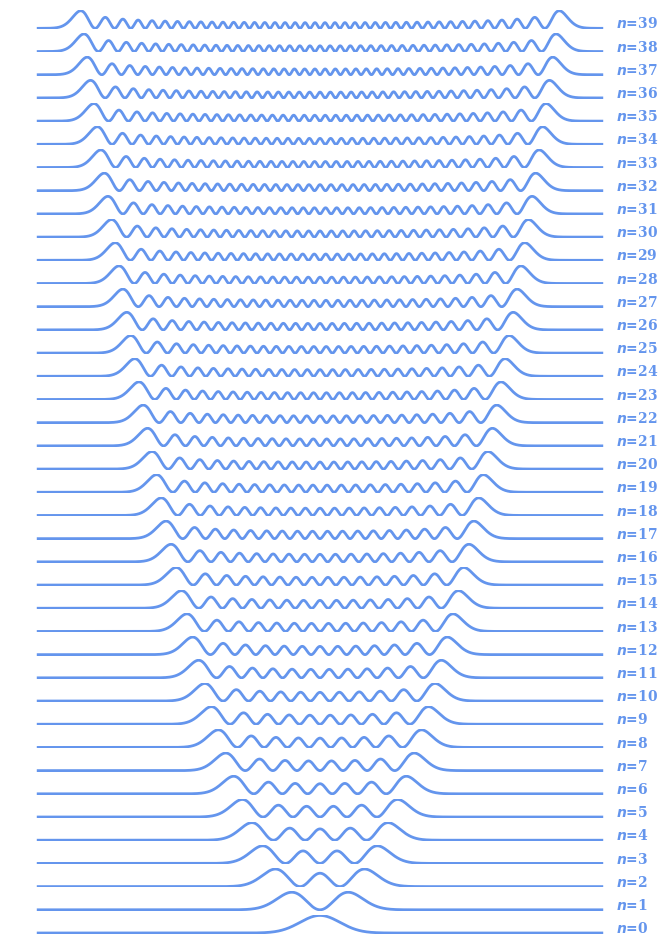

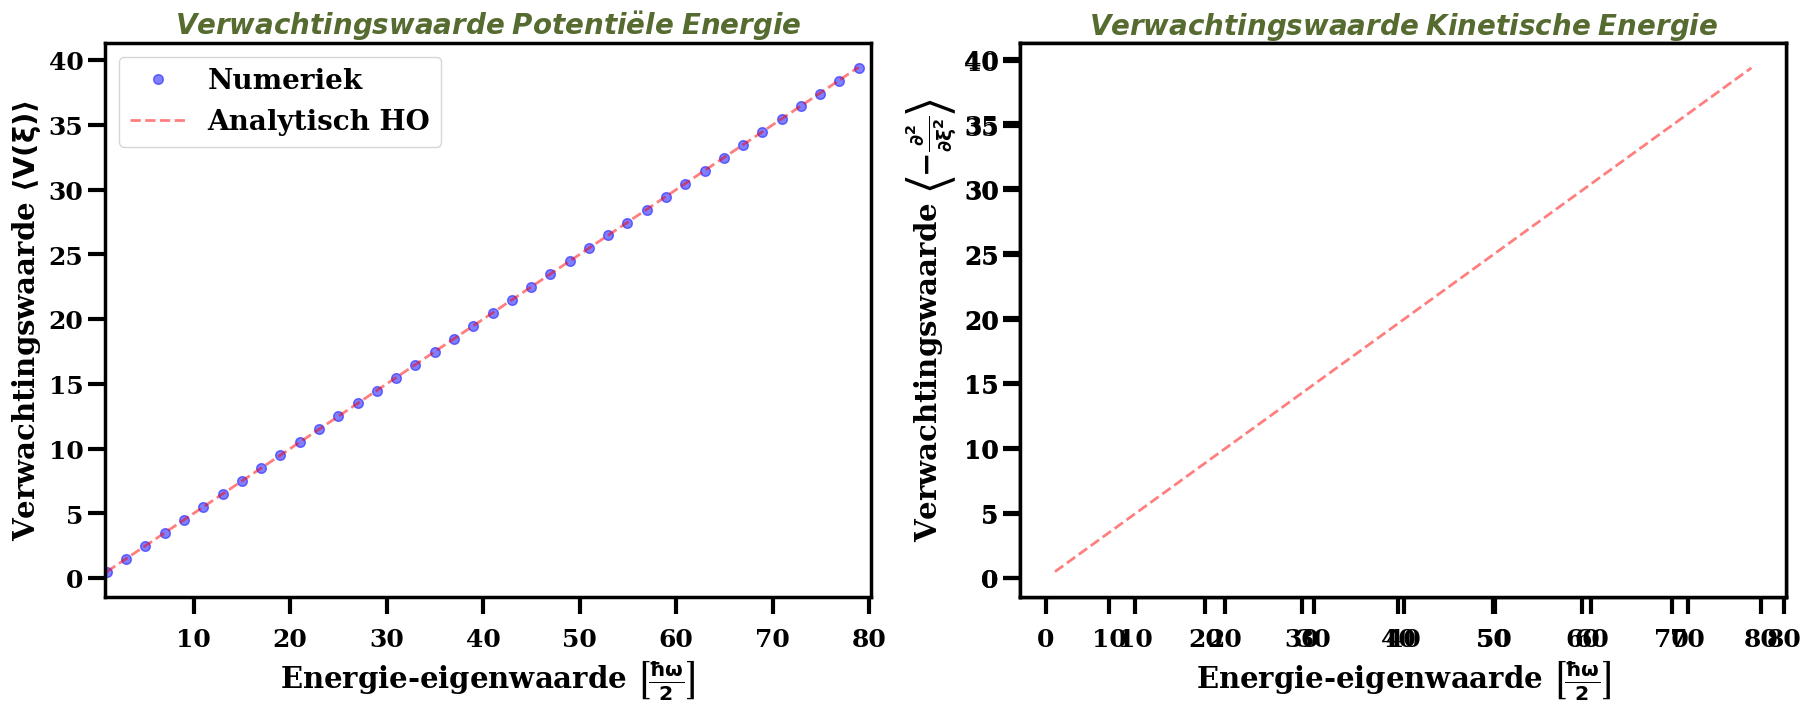

<Figure size 700x700 with 0 Axes>

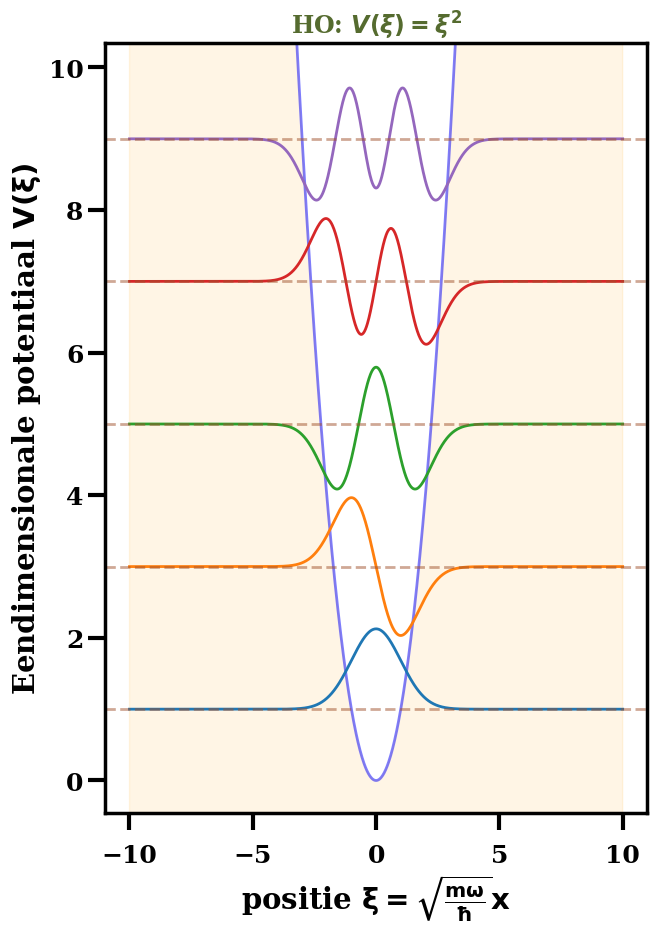

In [4]:
def sho_wavefunctions_plot(xmin = -10, xmax = 10, Nx = 1000, neigs = 40, params = [1.]):
    """
    Running the function sho_wavefunctions_plot plots the first neigs probability density function for the
    quantum harmonic oscillator!

    Args:
      xmin: lowest x value with a non-negligible value for wavefunction
      xmax: highest x value with a non-negligible value for wavefunction
      Nx: number of grid points
      neigs: expected number of energy eigenvalues
      params: value of \left( \frac{m \omega}{\hbar} \right) ^2

    """
    WatPot=1 # V(x) = HO : params[0] * x**2
    ScalWav=1.5 # scaling factor for wavefunctions
    eval_wavefunctions(xmin=xmin, xmax=xmax, Nx=Nx, WatPot=WatPot, params=params, neigs=neigs, findpsi=True , EndEner=80.,ScalWav=ScalWav)

sho_wavefunctions_plot()

#  $\color{orange}{\textbf{Voorbeeld 2: Een-dimensionale Bounded Harmonische Oscillator (1D-BHO)}}$

Voor een 1D-BHO: $V(x) = - \frac {V_0} {x^2+a^2}$. Dit is een voorbeeld van een systeem waarvoor de Schr$\ddot{o}$dinger-vergelijking geen analytische oplossingen heeft. De 1D-BHO is in veel situaties een meer fysische beschrijving van werkelijke situaties dan een 1D-HO: bij deze laatste kost het oneindig veel energie om het deeltje los te maken, terwijl bij de 1D-BHO een eindige hoeveelheid kost om een deeltje los te maken.

De TISE voor de 1D-BHO kan geschreven worden als:
$\left[ - \frac{ \hbar ^2} {2m} \frac {d^2} {d x ^2} - \frac {V_0} {x^2+a^2} \right] \psi  (x) = E \psi (x) $

De $V_0$ heeft de dimensie van energie en we kunnen een $\omega$ introduceren waarvoor $V_0 \equiv \hbar \omega$.

We drukken de energie uit in dimensieloze eenheden met als basis $\frac {\hbar \omega} {2}$: $ \widetilde{E} \equiv \frac {E} {\left( \frac {\hbar \omega} {2} \right)} $, introduceren de dimensieloze positie $\xi = \sqrt{\frac {m \omega}{\hbar}} x$ en $\widetilde{a} \equiv \sqrt{\frac {m \omega}{\hbar}} a $.

In deze eenheden wordt de TISE voor de 1D-BHO: $\left[ - \frac {d^2} {d \xi ^2} - \frac {2 \widetilde{a} ^2} {\xi^2 + \widetilde{a}^2} \right] \psi  (\xi) = \widetilde{E} \psi (\xi) $

**De gediscretiseerde TISE voor de 1D-BHO wordt:**

$ \bf - \frac{1}{\left(\Delta \xi \right)^2 } \left[ \psi _{n+1} -2  \psi _n + \psi _{n-1} \right] - \frac {2 \widetilde{a} ^2} {\xi _n ^2 + \widetilde{a}^2}
  \psi_n =  \widetilde{E} \psi_n \; \text{met,} \; \psi _n \equiv \psi (\xi _0 + n \Delta \xi)$.

De link tussen de 1D-BHO en de 1D-HO wordt duidelijk na een Taylor expansie van de potentiele energie: $- \frac {2 \widetilde{a} ^2} {\xi _n ^2 + \widetilde{a}^2} = -2 +2 \left( \frac{\xi _n}{\widetilde{a}} \right)^2 -2 \left( \frac{\xi _n}{\widetilde{a}} \right)^4 + \ldots  $, wat de volgende benaderende TISE voor de 1D-BHO oplevert (enkel geldig voor $\frac{\xi}{\widetilde{a}} \ll 1$):

$ \frac{\xi}{\widetilde{a}} \ll 1 \; \; : \; - \frac{1}{\left(\Delta \xi \right)^2 } \left[ \psi _{n+1} -2  \psi _n + \psi _{n-1} \right] + \left[ 2 \left( \frac{\xi _n}{\widetilde{a}} \right)^2 -2 \left( \frac{\xi _n}{\widetilde{a}} \right)^4  \right]
  \psi_n \approx \left[ 2 +  \widetilde{E} \right] \psi_n \;  $.

Voor $\widetilde{a}=\sqrt{2}$ verwachten we dus energie-eigenwaarden die voor lage waarden die van de 1D-HO benaderen op een verschuiving -2  na.






 Enkel de negatieve energie-eigenwaarden corresponderen met gebonden toestanden! 


Energy eigenvalues (for units consult the explanations for the different potentials):
  1: -1.5997     2: -0.9390     3: -0.5214     4: -0.2755     5: -0.1363     6: -0.0411     7: 0.0597     8: 0.1843   
  9: 0.3329    10: 0.5039    11: 0.6965    12: 0.9101    13: 1.1442    14: 1.3984    15: 1.6727   

/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/971731535.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.conj(
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi2[n]=np.trapz(np.multiply(H[3],y),H[2]) # <V(x)>
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dxi2[n]=-np.trapz(dyy,H[2]) # < - \partial ^2 / \partial xi**2>


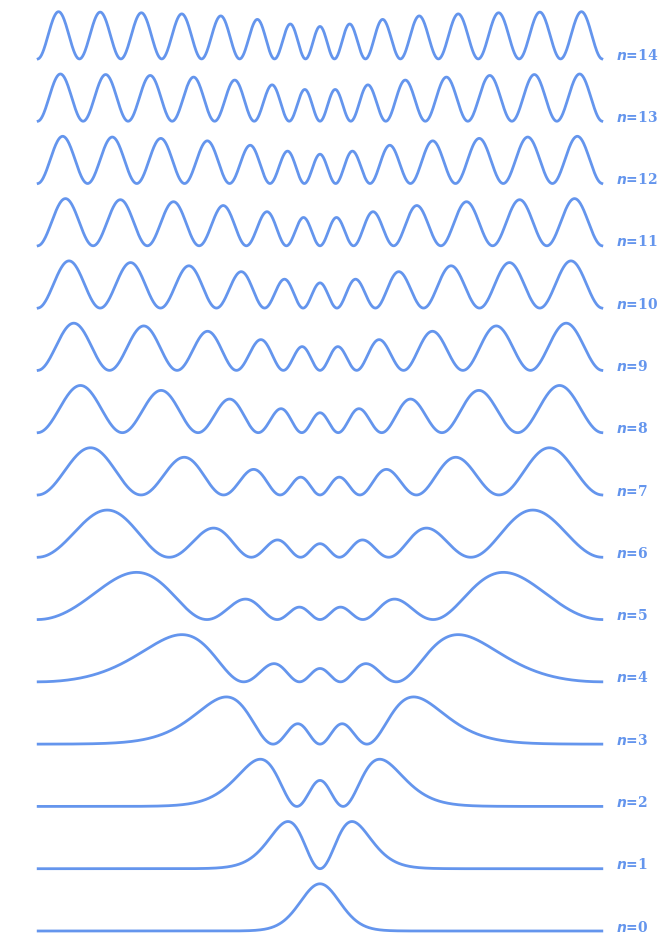

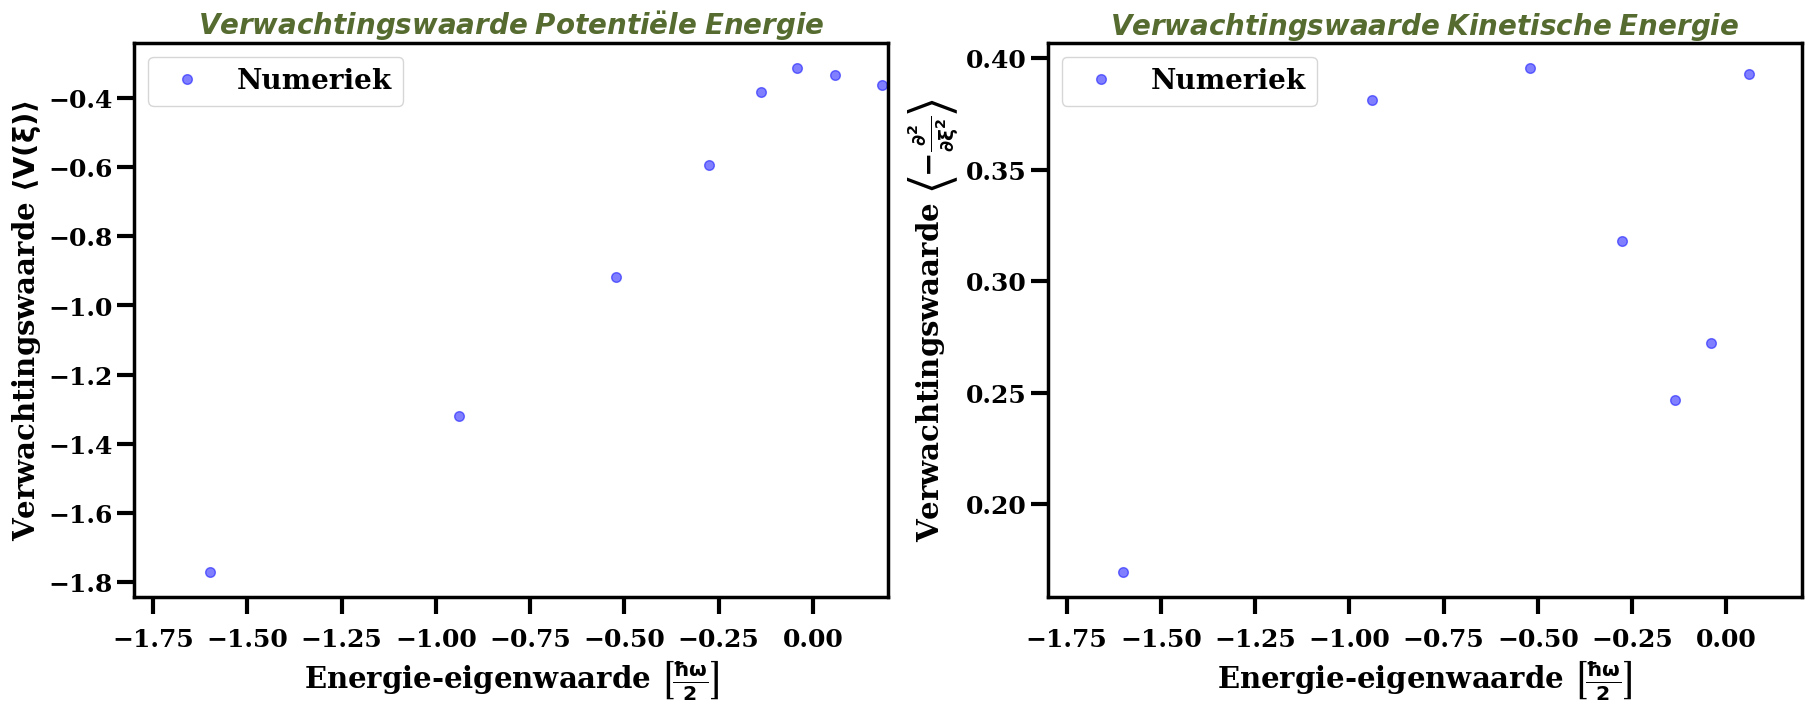

<Figure size 700x700 with 0 Axes>

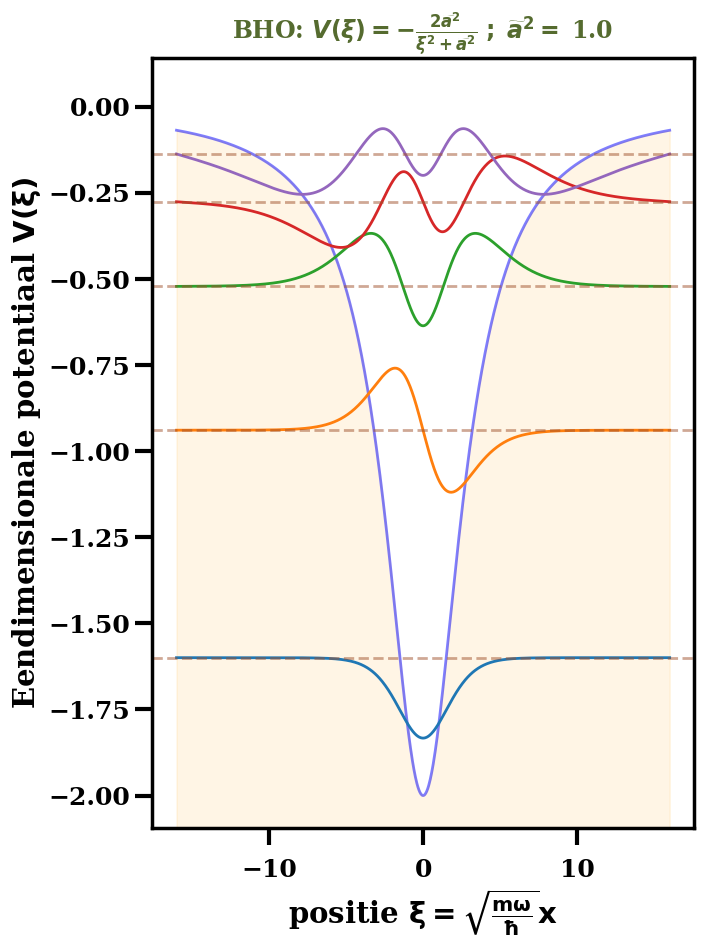

In [5]:
def bho_wavefunctions_plot(xmin = -16, xmax = 16, Nx = 1000, neigs = 15, params = [1.,3.]):
    """
    Running the function bho_wavefunctions_plot plots the first neigs probability density function for the
    BOUNDED quantum harmonic oscillator!

    Args:
      xmin: lowest x value with a non-negligible value for wavefunction
      xmax: highest x value with a non-negligible value for wavefunction
      Nx: number of grid points
      neigs: expected number of energy eigenvalues
      params:

    """
    WatPot=2 # Bounded HO Oscillator ...
    ScalWav=0.4 # scaling factor for wavefunctions
    print(2*"\n","Enkel de negatieve energie-eigenwaarden corresponderen met gebonden toestanden!",2*"\n")
    eval_wavefunctions(xmin=xmin, xmax=xmax, Nx=Nx, WatPot=WatPot, params=params, neigs=neigs, findpsi=True, EndEner=0.,ScalWav=ScalWav)


bho_wavefunctions_plot()

#  $\color{orange}{\textbf{Voorbeeld 3: Een-dimensionale Morse potentiaal (1D-Morse)}}$

Voor een 1D-Morse: $V(x) = D_e \left(1 - \exp \left( -a x\right) \right)^2$. De Morse potentiaal speelt een belangrijke rol in moleculaire fysica (zie: https://en.wikipedia.org/wiki/Morse_potential)

De TISE voor de 1D-Morse kan geschreven worden als:
$\left[ - \frac{ \hbar ^2} {2m} \frac {d^2} {d x ^2} +
  D_e \left(1 - \exp \left( -a x\right) \right)^2 \right] \psi  (x) = E \psi (x) $

De $D_e$ heeft de dimensie van energie. We drukken de energie uit in dimensieloze eenheden met als basis $D_e$: $ \widetilde{E} \equiv \frac {E} {D_e} $ en we introduceren de dimensieloze positie $\xi = a x$ ($a$ heeft als dimensie $\frac{1}{lengte}$).

Na introductie van de dimensieloze grootheid:

$\frac{1}{\lambda ^2} = \frac {\hbar ^2 a^2} {2 m D_e} $

kan de TISE herschreven worden als:

$ \left[ - \frac {d^2} {d \xi ^2} + \lambda ^2 \left(1 - \exp \left( - \xi \right) \right)^2 \right] \psi  (\xi) = \lambda ^2 \widetilde{E} \psi  (\xi) $.

Niet triviale technieken leren dat deze vergelijking de volgende energie-eigenwaarden heeft:

$ \lambda ^2 \widetilde{E} = \lambda ^2 - \left( \lambda -n - \frac {1} {2} \right)^2 \; \; , \; n \in \left\{0, 1, 2, \ldots, int(\lambda - \frac {1} {2}) \right\}$ met $int(\lambda - \frac {1} {2})$ de grootste integer kleiner dan $(\lambda - \frac {1} {2})$.


<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/2338220229.py:11: SyntaxWarning: invalid escape sequence '\l'
  params: value of \lambda ^2


Energy eigenvalues (for units consult the explanations for the different potentials):
  1: 5.7499     2: 15.7496     3: 23.7494     4: 29.7493     5: 33.7684     6: 36.4303     7: 39.4627     8: 43.3005   
  9: 47.8216    10: 52.9547   

/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/971731535.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.conj(
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi2[n]=np.trapz(np.multiply(H[3],y),H[2]) # <V(x)>
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dxi2[n]=-np.trapz(dyy,H[2]) # < - \partial ^2 / \partial xi**2>


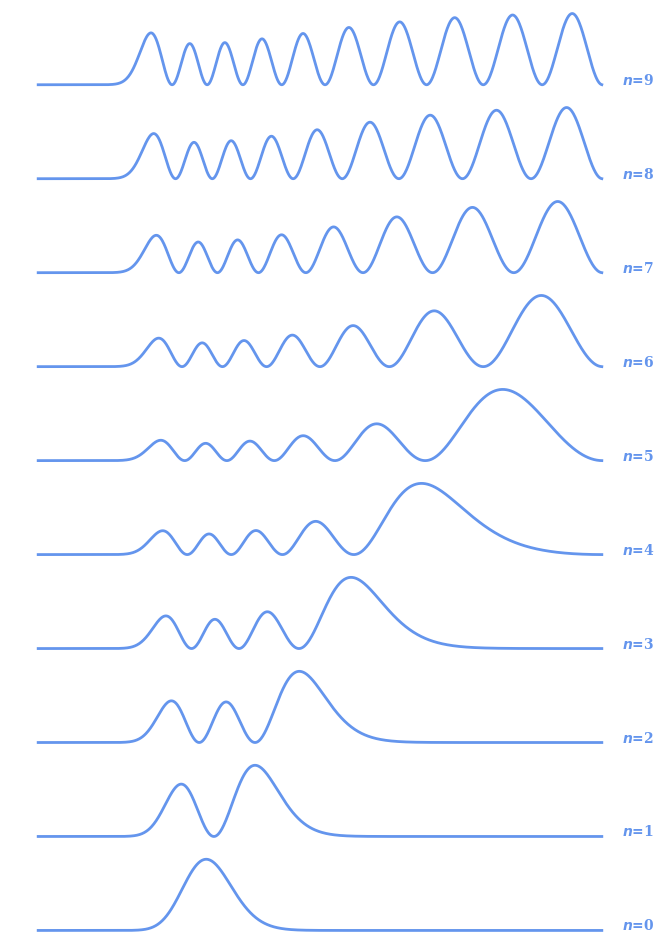

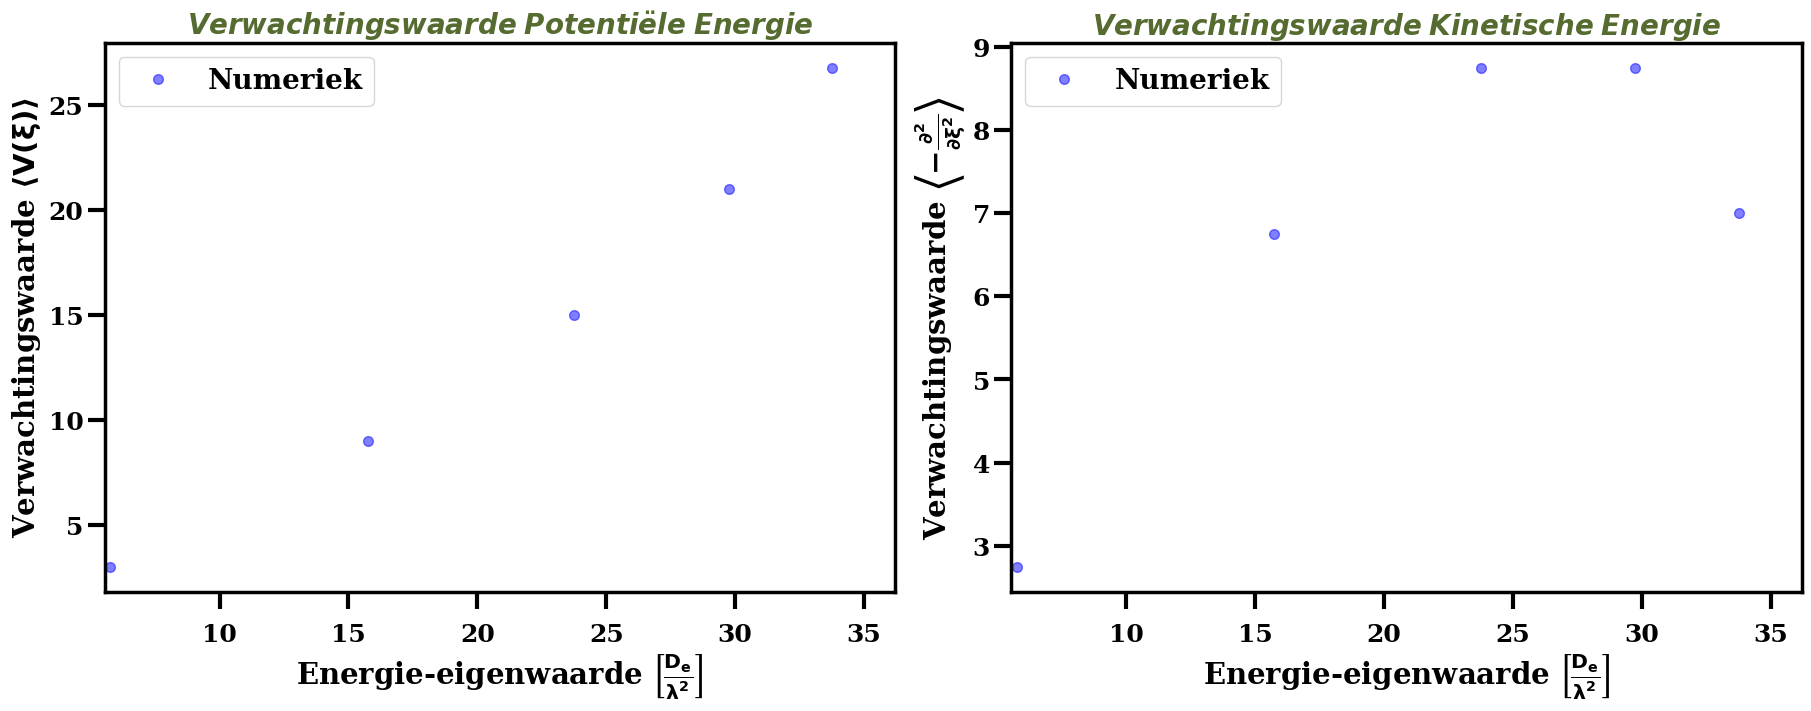

<Figure size 700x700 with 0 Axes>

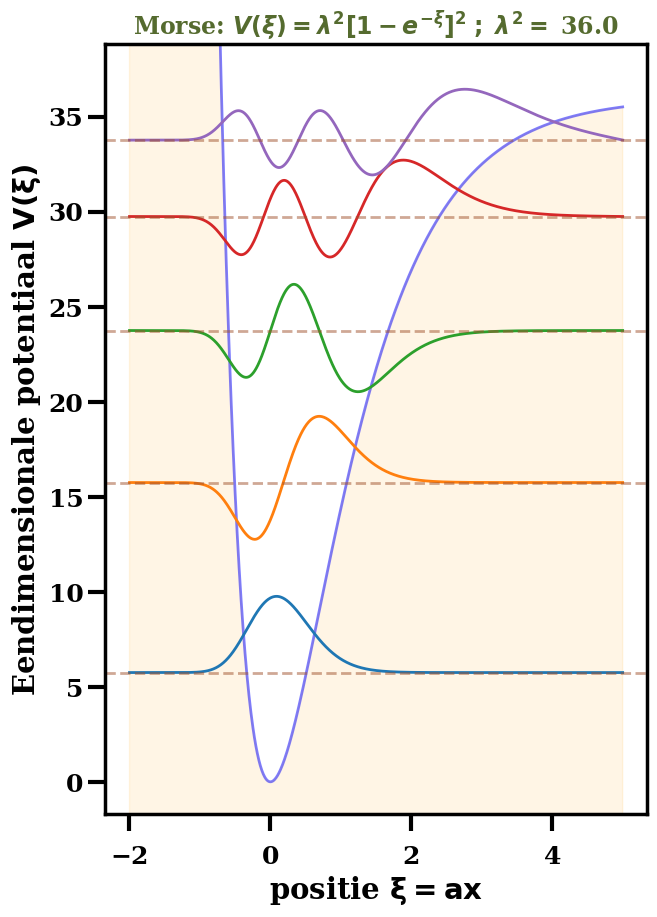

In [6]:
def Morse_wavefunctions_plot(xmin = -2, xmax = 5, Nx = 1000, neigs = 10, params = [36.]):
    """
    Running the function Morse_wavefunctions_plot plots the first neigs probability density function for the
    Morse potential !

    Args:
      xmin: lowest x value with a non-negligible value for wavefunction
      xmax: highest x value with a non-negligible value for wavefunction
      Nx: number of grid points
      neigs: expected number of energy eigenvalues
      params: value of \lambda ^2

    """
    WatPot=3 # Morse potentiaal...
    ScalWav=3.5 # scaling factor for wavefunctions (for the plot with wave functionsin the potential)
    eval_wavefunctions(xmin=xmin, xmax=xmax, Nx=Nx, WatPot=WatPot, params=params, neigs=neigs, findpsi=True, EndEner=params[0],ScalWav=ScalWav)


Morse_wavefunctions_plot()

#  $\color{orange}{\textbf{Voorbeeld 4: Een-dimensionale ``Mexican hat'' potentiaal (1D-MH)}}$

Voor een 1D-MH: $V(x) = V_0 - \frac {1} {2} k x^2 + \frac {1} {4} \lambda x^4$. De ``Mexican hat'' (of sombrero) potentiaal speelt een belangrijke rol in de fysica (zie:  https://en.wikipedia.org/wiki/Spontaneous_symmetry_breaking#Sombrero_potential). De parameter $k$ is een positieve grootheid met dimensie $[k]=E \cdot L^{-2}$. De parameter $\lambda$ is een positieve grootheid met dimensie $[\lambda]=E \cdot L^{-4}$.

Merk op dat: $V(x=0) = V_0$ (een lokaal maximum); $\lim _{x \to + \infty} V(x) = + \infty$; en $V(x)$ bereikt een lokaal minimum bij $x = \pm \sqrt{\frac{k} {m}}$:
$V(x = \pm \sqrt{\frac{k} {m}}) = V_0 - \frac {k^2} {4 \lambda} $.

De TISE voor de 1D-MH kan geschreven worden als:
$\left[ - \frac{ \hbar ^2} {2m} \frac {d^2} {d x ^2} +
\left( V_0 - \frac {1} {2} k x^2 + \frac {1} {4} \lambda x^4 \right)
\right] \psi  (x) = E \psi (x) $

We drukken de energie uit in dimensieloze eenheden met als eenheid $V_0$: $ \widetilde{E} \equiv \frac {E} {V_0} $ en we introduceren de dimensieloze positie $\xi = \sqrt{\frac{\lambda}{k}} x$ ($\sqrt{\frac{\lambda}{k}}$ heeft als dimensie $\frac{1}{lengte}$). Merk op dat de minima van de potentiaal dus overeenstemmen met $\xi = \pm 1$.

Na introductie van de twee dimensieloze grootheden:

$\frac{1}{\kappa ^2} = \frac {\hbar ^2} {2 m V_0\frac {k} {\lambda}}
\; \text{en,} \;
\eta ^2 = \frac {m \lambda} {2 \hbar ^2}\left( \frac {k} {\lambda} \right) ^3 \; ,
$

kan de TISE voor de 1D-MH herschreven worden als:

$ \left[ - \frac {d^2} {d \xi ^2} + \left( \kappa ^2 + \eta ^2  
\left(\xi ^4 - 2 \xi ^2 \right) \right) \right] \psi  (\xi) = \kappa ^2 \widetilde{E} \psi  (\xi) $.

Na oplossing van deze TISE worden de eigenwaarden dus bekomen als $\epsilon = \kappa ^2 \widetilde{E} = \kappa ^2 \frac{E} {V_0}$. De potentiaal in dimensieloze grootheden $V(\xi)= \left( \kappa ^2 + \eta ^2  
\left(\xi ^4 - 2 \xi ^2 \right) \right)$ heeft dus na herformulering van het probleem in dimensieloze grootheden de twee parameters $\left(\kappa ^2, \eta ^2 \right)$. Dit is geheel logisch in het licht van het feit dat de potentiaal bepaald wordt door twee onafhankelijke parameters $\left(k, \lambda \right)$.

Bij de bepaling van een set parameters $\left(\kappa ^2, \eta ^2 \right)$ kan men in het achterhoofd houden dat: $V(\xi =0) = \kappa ^2$ en dat de minima worden gegeven door $V(\xi = \pm 1) = \kappa ^2 -\eta ^2$. Merk op dat $\eta ^2$ de helling van de potentiaal bepaalt.

De afleiding van de gediscretiseerd vorm van de TISE voor de 1D-MH is volledig analoog aan wat hierboven uit de doeken werd gedaan voor de 1D-HO en de 1D-BHO.




Energy eigenvalues (for units consult the explanations for the different potentials):
  1: -0.8282     2: 0.2014     3: 6.1676     4: 11.4757     5: 18.2706     6: 25.8530     7: 34.1591     8: 43.0919   
  9: 52.5860    10: 62.5903   

/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/971731535.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.conj(
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi2[n]=np.trapz(np.multiply(H[3],y),H[2]) # <V(x)>
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dxi2[n]=-np.trapz(dyy,H[2]) # < - \partial ^2 / \partial xi**2>


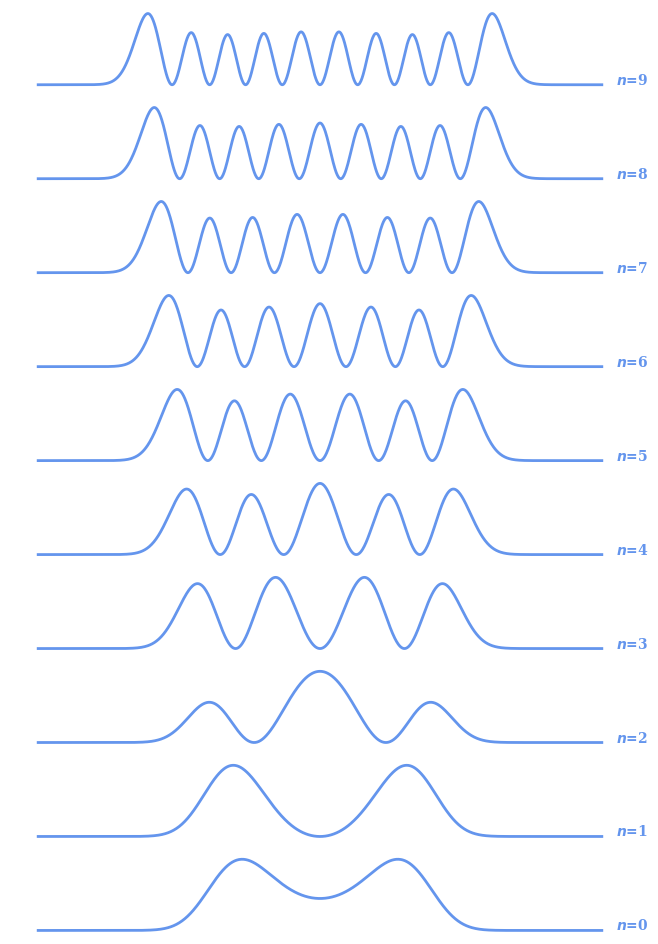

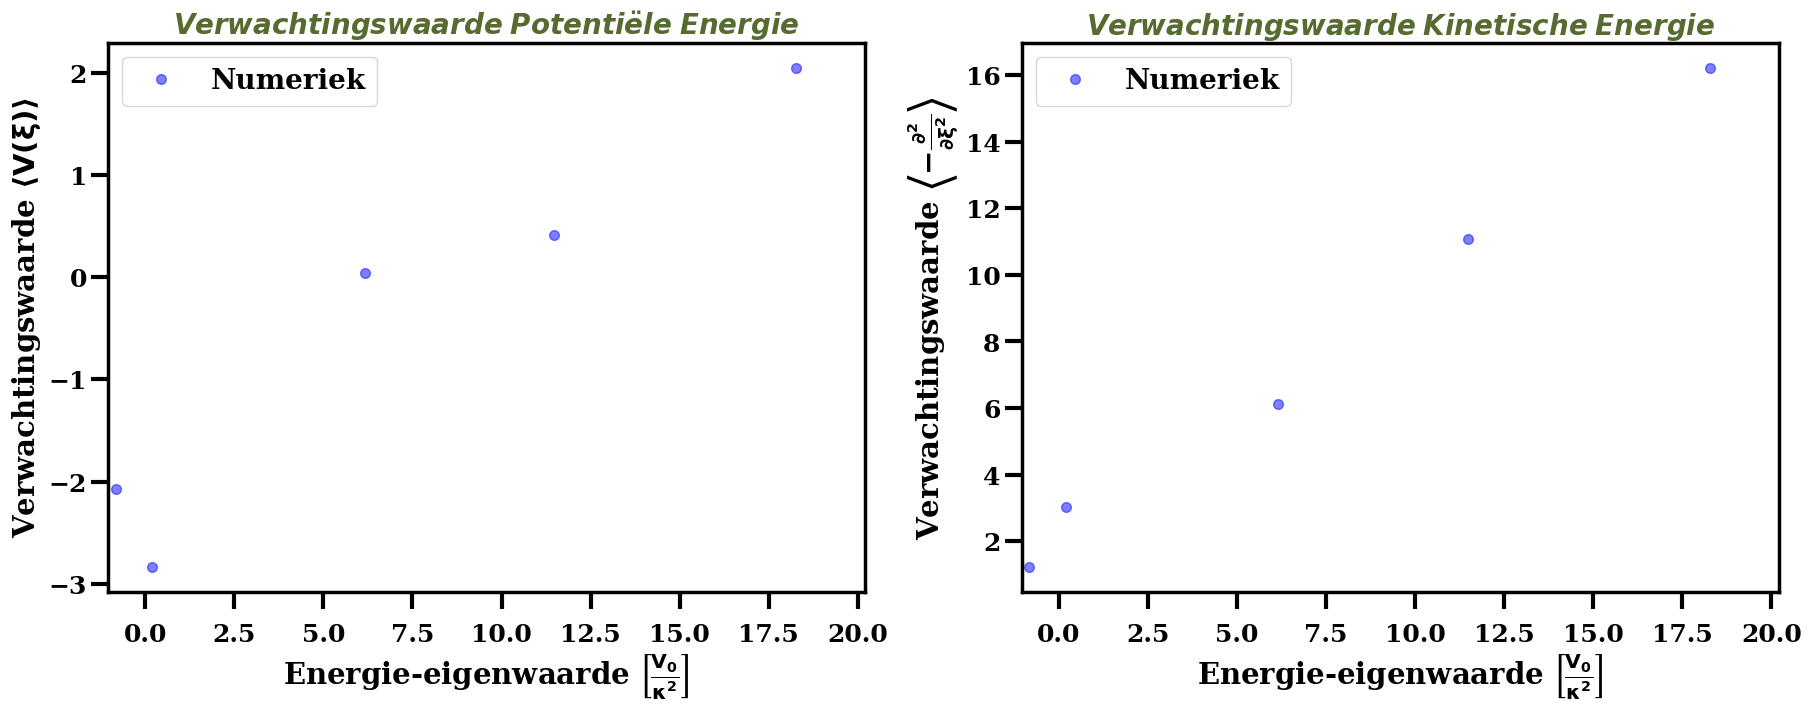

<Figure size 700x700 with 0 Axes>

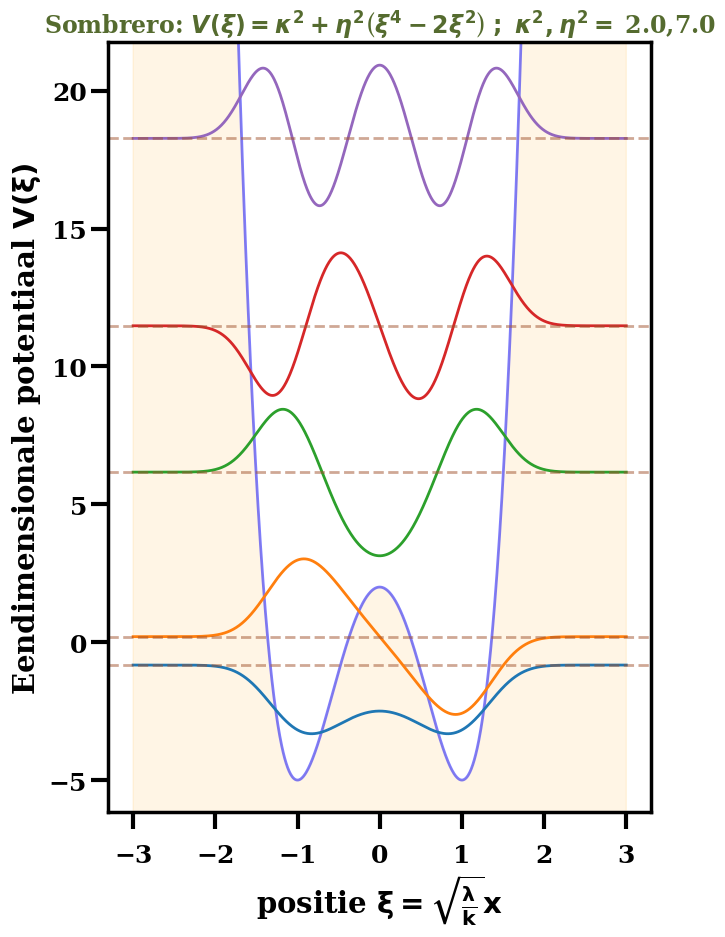

In [7]:
def Mexican_wavefunctions_plot(xmin = -3., xmax = 3., Nx = 1000, neigs = 10, params = [2.,7.]):
    """
    Running the function Mexican_wavefunctions_plot plots the first neigs probability density functions for the
    Mexican Hat potential

    Args:
      xmin: lowest x value with a non-negligible value for wavefunction
      xmax: highest x value with a non-negligible value for wavefunction
      Nx: number of grid points
      neigs: expected number of energy eigenvalues
      params: params[0] value of kappa ^2 ; params[1] value of eta ^2 in V(xi)=  kappa ^2 + eta ^2 (xi ^4 - 2 xi ^2 )

    """
    WatPot=4 # Morse potentiaal...
    ScalWav=3.5 # scaling factor for wavefunctions (for the plot in the potential)
    EndEner=20. # 2.*params[0]
    eval_wavefunctions(xmin=xmin, xmax=xmax, Nx=Nx, WatPot=WatPot, params=params, neigs=neigs, findpsi=True, EndEner=EndEner,ScalWav=ScalWav)


Mexican_wavefunctions_plot()

#  $\color{orange}{\textbf{Voorbeeld 5:  Een-dimensionale ``mystery'' potentiaal (1D-myst)}}$

Dit is een voorbeeld van een potentiaal die een discontinuiteit bevat die ervoor moet zorgen dat de beweging van het deeltje beperkt is tot het interval $0 \le x < + \infty$.  De potentiaal heeft de volgende vorm: $ V (x \le 0) = + \infty$ en $ V (x > 0) = C + \frac {\hbar ^2 B^2}{2m} \left( 1 - \frac {2} {x B}\right) $. Het is duidelijk dat $C$ de dimensie heeft van energie en $B$ de dimensie van $\frac{1}{lengte}$.

Na introductie van dimensieloze positie-coordinaat $\xi = x B $ en de dimensieloze grootheid $\frac {1} {\lambda ^2} \equiv \frac {\hbar ^2 B ^2}{2 m C}$ kan de TISE geschreven worden als:

$\left[ - \frac {d^2} {d \xi ^2} + \left( \lambda ^2 +   
\left(1  - \frac {2} {\xi} \right) \right) \right] \psi  (\xi > 0) = \left[  \lambda ^2 \frac {E} {C} \right] \psi  (\xi > 0)$.

Men heeft dus: $ V (\xi \le 0) = + \infty$ en $ V (\xi > 0) = \lambda ^2 +   
\left(1  - \frac {2} {\xi} \right) $

Bij de keuze van parameters is het van belang om rekening te houden met het feit dat $V(\xi=1)= \lambda ^2 -1 \; ; \; V(\xi=2)= \lambda ^2 \; ; \; \lim _{\xi \gg 2} V(\xi) = \lambda ^2 +1 \; ; \; \lim _{\xi \to 0} V(\xi) = -\infty \; .$ We kiezen $C=1$ zodat enkel $\lambda ^2$ een vrije parameter is.

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/1681712303.py:11: SyntaxWarning: invalid escape sequence '\l'
  params: params[0] value of lambda ^2 in V(xi)= \lambda ^2 + (1 - 2/xi)


Energy eigenvalues (for units consult the explanations for the different potentials):
  1: 17.7184     2: 18.3487     3: 18.8946     4: 19.7168     5: 20.8020     6: 22.1440   

/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/971731535.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.conj(
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi2[n]=np.trapz(np.multiply(H[3],y),H[2]) # <V(x)>
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dxi2[n]=-np.trapz(dyy,H[2]) # < - \partial ^2 / \partial xi**2>


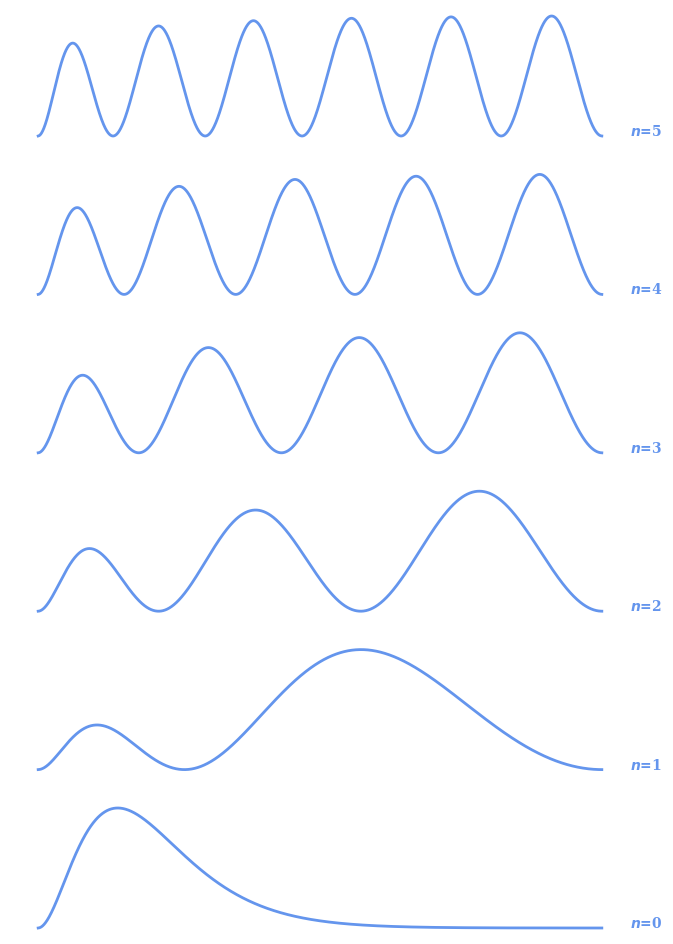

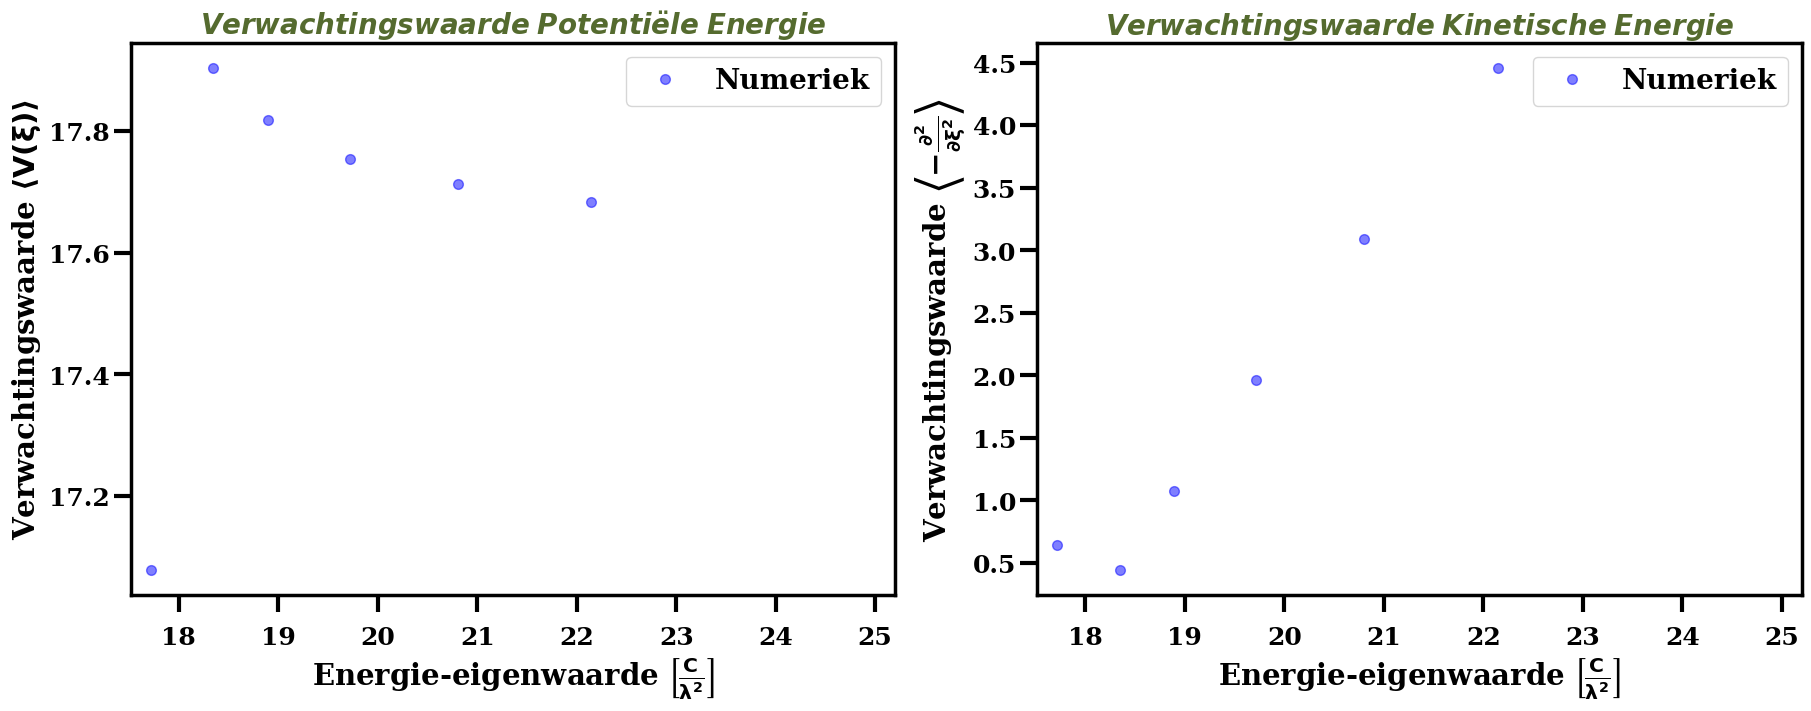

<Figure size 700x700 with 0 Axes>

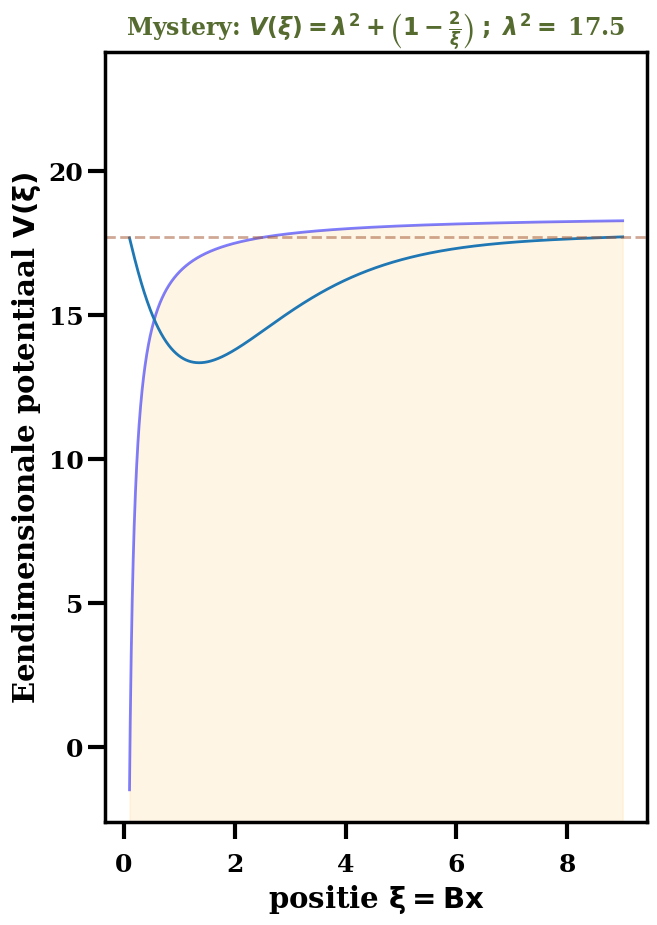

In de mystery potential: nauwelijks mogelijk om gebonden toestand te hebben!
De energie-eigenwaarde van grondtoestand is gekend (=C). Voor gebruikte parameterkeuze en eenheden gelijk aan 17.5


In [8]:
def Mystery_wavefunctions_plot(xmin = 0.10, xmax = 9.0, Nx = 2000, neigs = 6, params = [17.5]):
    """
    Running the function Mystery_wavefunctions_plot plots the first neigs probability density functions for the
    Mystery potential.

    Args:
      xmin: lowest x value with a non-negligible value for wavefunction - should be > 0 (stay away from singularity ....)
      xmax: highest x value with a non-negligible value for wavefunction
      Nx: number of grid points
      neigs: expected number of energy eigenvalues (at least 5 ...)
      params: params[0] value of lambda ^2 in V(xi)= \lambda ^2 + (1 - 2/xi)

    """
    WatPot=5 # Mystery potentiaal...
    ScalWav=6.5 # scaling factor for wavefunctions (for the plot in the potential)
    EndEner=  25. # 2.*params[0]
    eval_wavefunctions(xmin=xmin, xmax=xmax, Nx=Nx, WatPot=WatPot, params=params, neigs=neigs, findpsi=True, EndEner=EndEner,ScalWav=ScalWav)
    print("In de mystery potential: nauwelijks mogelijk om gebonden toestand te hebben!")
    print("De energie-eigenwaarde van grondtoestand is gekend (=C). Voor gebruikte parameterkeuze en eenheden gelijk aan {0}".format(params[0]))

Mystery_wavefunctions_plot()

#  $\color{orange}{\textbf{Voorbeeld 6:  Een-dimensionale Lennard-Jonespotentiaal (1D-LJ)}}$

Dit is een voorbeeld van een potentiaal die aanleiding geeft tot een kracht die:  (ii) heel hard repulsief is voor $x \le \sigma$; (ii) matig attractief is over een relatief kleine afstand voor $x > \sigma$. De potentiaal is van dien aard dat de beweging van het deeltje beperkt is tot het interval $0 \le x < + \infty$.  De potentiaal heeft de volgende vorm:

$ V (x > 0) = \epsilon \left[ \left( \frac {\sigma} {x} \right)^{12} -2 \left( \frac {\sigma} {x} \right)^6  \right]$.

Deze potentiaal bevat twee parameters $(\epsilon >0,\sigma >0)$. Het is duidelijk dat $\epsilon $ de dimensie heeft van ${energie}$ en $\sigma$ de dimensie van ${lengte}$.  Men heeft dat de potentiaal een minimum bereikt bij $x=\sigma$: $V(x=\sigma)=- \epsilon$.

Na introductie van dimensieloze positie-coordinaat $\xi = \frac{x} {\sigma} $ en de dimensieloze grootheid $\frac {1} {\lambda ^2} \equiv \frac {\hbar ^2}{2 m \epsilon \sigma ^2}$ kan de TISE geschreven worden als:

$\left[ - \frac {d^2} {d \xi ^2} + \bigl[ \lambda ^2    
\left({\xi}^{-12} - 2 \xi ^ {-6} \right) \bigr] \right] \psi  (\xi > 0) = \left[   \frac {E\lambda ^2} {\epsilon} \right] \psi  (\xi > 0)$.

Men heeft dus: $ \lim _{\xi \rightarrow 0} V (\xi) = + \infty$, $ V (\xi =1) = - \lambda ^2 $, $ \lim _{\xi \rightarrow + \infty } V (\xi) = +0$. Eigenlijk hebben we dat $V (\xi \ge 3) \approx  0$. Het betreft dus een deeltje die hard wordt weggeduwd uit de oorsprong en matig wordt gebonden in het interval $+1 \lesssim \xi \lesssim +3$.

We kiezen de energie-schaal $\epsilon=1$ zodat enkel $\lambda ^2$ een vrije parameter is. Het vinden van de energie-eigenwaarden met bijbehorende energie-eigenfuncties van de 1D Lennard-Jones potentiaal kan analytisch aangepakt worden (zie bijvoorbeeld https://arxiv.org/pdf/1405.5987) maar hier gaan we voor een numerieke oplossing. Het is hierbij van belang om de onderlimiet van $\xi$ niet bij 0 te laten beginnen (waar $ \lim _{\xi \rightarrow 0} V (\xi) = + \infty$) maar bij een eindige en positieve waarde van $\xi$ (in de buurt van 0 waar $V(\xi)$ groot en positief is maar niet oneindig).   

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/637517646.py:11: SyntaxWarning: invalid escape sequence '\l'
  params: params[0] value of lambda ^2 in V(xi)= \lambda ^2 (xi ^ {-12} -2 xi ^ {-6})


Energy eigenvalues (for units consult the explanations for the different potentials):
  1: -39.7454     2: -2.6777   


/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/971731535.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.conj(
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi2[n]=np.trapz(np.multiply(H[3],y),H[2]) # <V(x)>
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dxi2[n]=-np.trapz(dyy,H[2]) # < - \partial ^2 / \partial xi**2>


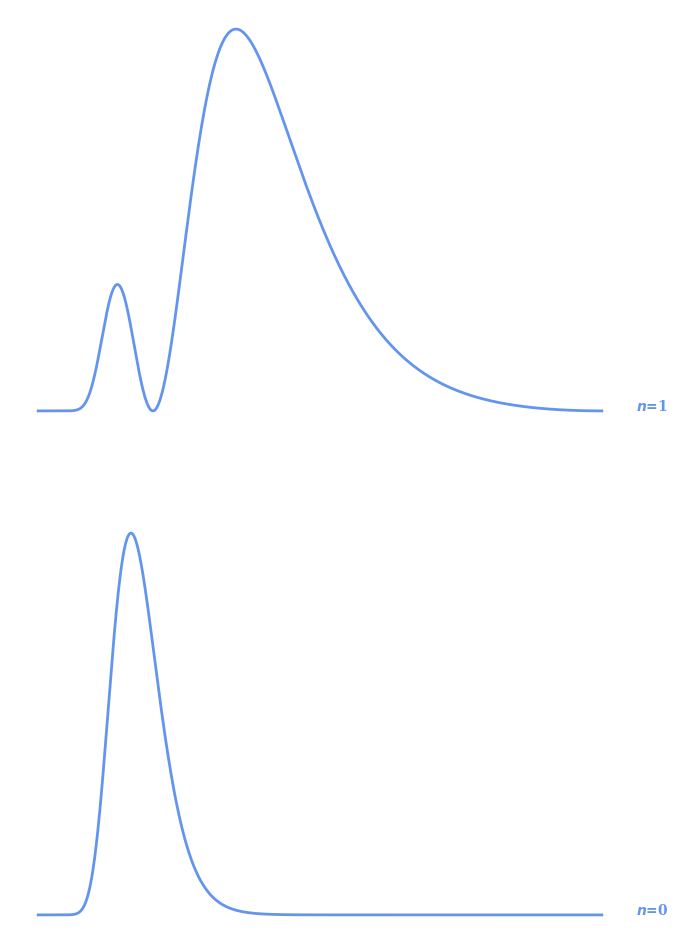

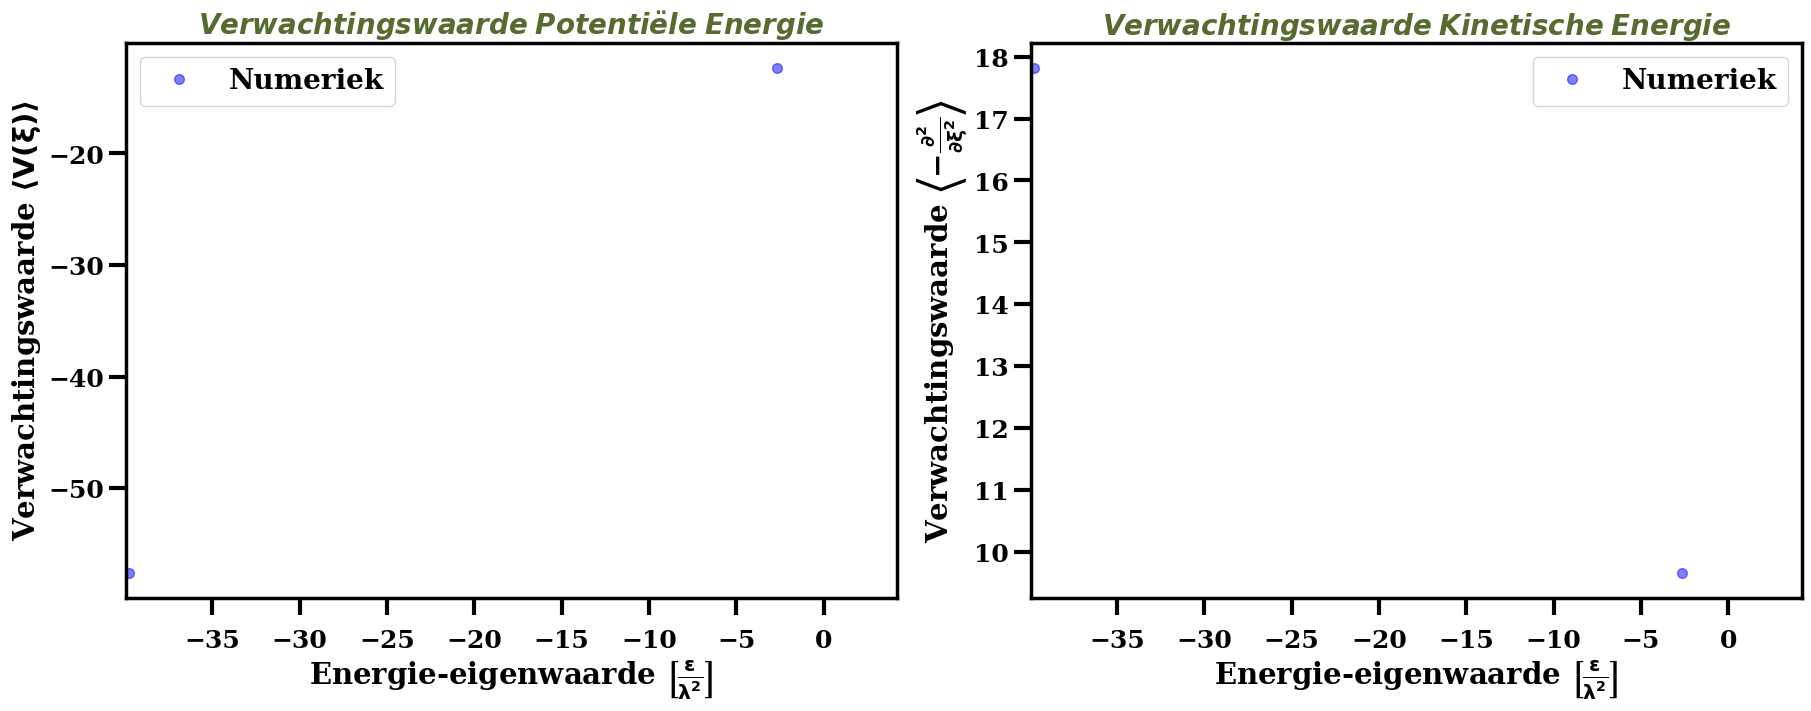

<Figure size 700x700 with 0 Axes>

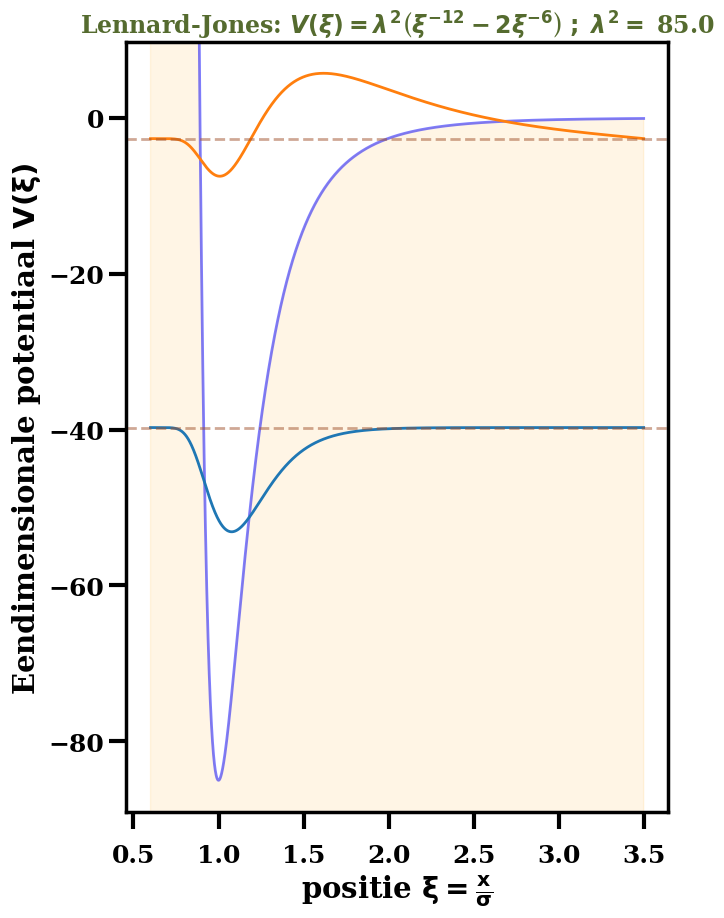

In [9]:
def LennardJones_wavefunctions_plot(xmin = 0.60, xmax = 3.5, Nx = 3000, neigs = 2, params = [85.]):
    """
    Running the function LennardJones_wavefunctions_plot plots the first neigs probability density functions for the
    Mystery potential !

    Args:
      xmin: lowest x value with a non-negligible value for wavefunction - should be > 0 (stay away from singularity: xmin=0.6 seems to give good results)
      xmax: highest x value with a non-negligible value for wavefunction
      Nx: number of grid points
      neigs: expected number of energy eigenvalues
      params: params[0] value of lambda ^2 in V(xi)= \lambda ^2 (xi ^ {-12} -2 xi ^ {-6})

    """
    WatPot=6 # Lennard-Jones potentiaal...
    ScalWav=7.5 # scaling factor for wavefunctions (for the clarity of the plot in the potential)
    EndEner=  4. # bound states of Lennard-Jones have a negative energy
    eval_wavefunctions(xmin=xmin, xmax=xmax, Nx=Nx, WatPot=WatPot, params=params, neigs=neigs, findpsi=True, EndEner=EndEner,ScalWav=ScalWav)


LennardJones_wavefunctions_plot()

#  $\color{orange}{\textbf{Voorbeeld 7:  Een-dimensionale symmetrische lineaire potentiaal (1D-LIN)}}$

Dit is een voorbeeld van een potentiaal die aanleiding geeft tot een constante aantrekkende kracht die het deeltje naar de oorspong duwt.   De potentiaal heeft de volgende vorm:

$ V (-\infty < x < + \infty) =  b \left| {x} \right|$.

Deze potentiaal bevat een parameter $(b >0)$. Het is duidelijk dat $b$ de dimensie heeft E.L$^{-1}$ ($\frac{energie}{lengte}$).

We introduceren de volgende grootheid met dimensie lengte:

$\alpha \equiv \left( \frac{\hbar ^2} {2 m b} \right) ^{\frac {1} {3}} \; $.

Na introductie van de dimensieloze positie-coordinaat $\xi = \frac{x} {\alpha} $ en de dimensieloze grootheid

$\frac {1} {\lambda ^2} \equiv \frac {\hbar ^2}{2 m \epsilon \alpha ^3} = 1$ kan de TISE geschreven worden als:

$\left[ - \frac {d^2} {d \xi ^2} + \left| \xi \right|  \right]
\psi  (-\infty < \xi < + \infty ) = \left[   \frac {E} {b \alpha} \right] \psi  (-\infty < \xi  < + \infty )$.

De combinatie $b \alpha $ heeft de dimensie van energie en kan vrij gekozen worden. Het is perfect mogelijk om de energie-eigenwaarden van de TISE te bekomen in de energie-eenheid $\left( b \alpha \right)$.

Beperken we ons tot de situatie $\xi > 0$ dan wordt de bovenstaande TISE:

$\left[ - \frac {d^2} {d \xi ^2} +  \xi   \right]
\psi  (0 \le \xi < + \infty ) = \left[   \frac {E} {b \alpha} \right] \psi  (0 \le \xi  < + \infty )$.

Na introductie van de variabele $s = \xi - \frac {E} {b \alpha}$ wordt de TISE

$\frac {d^2 \psi (s)} {d s ^2} -s \psi (s)=0$.

De oplossingen van deze differentiaalvergelijking zijn de zogenaamde Airy functies (https://en.wikipedia.org/wiki/Airy_function).  

Een gekende toepassing is een botsende bal waarvoor er geen waarschijnlijkheid is om de bal te vinden bij $z<0$. De potentiaal van de botsende bal kan dus geschreven worden als: $V(z <0) = +\infty \; ; \; V(z \ge 0) = mgz$. Het is duiddelijk dat dit een speciaal geval is van een een-dimensionale lineaire potentiaal ($b = m g$). Meer info te vinden via: https://www.classe.cornell.edu/~dlr/teaching/p443/LinearPotential.pdf. Gekend resultaat is dat de laagste energie-eigenwaarden in de eenheden $b \alpha = m g \alpha= \left( \frac {\hbar ^2 m g ^2} {2} \right) ^ {\frac {1} {3}}$ zijn: 2.34, 4.09, en 5.52.  Merk op dat de voorwaarde $V(x<0)=+\infty$ maakt dat enkel de energie-eigenfuncties die corresponderen met een golffunctie met  $ \psi (\xi=0)=0$ fysisch mogelijk zijn: dit zijn al de energie-eigenwaarden van $V(\xi) = \left| \xi \right|$ die corresponderen met een toestand van oneven pariteit.




Energy eigenvalues (for units consult the explanations for the different potentials):
  1: 1.0188     2: 2.3381     3: 3.2482     4: 4.0879     5: 4.8201     6: 5.5205     7: 6.1633     8: 6.7868   

/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/971731535.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.conj(
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi2[n]=np.trapz(np.multiply(H[3],y),H[2]) # <V(x)>
/var/folders/9s/8sbwt7bs0m15y39npx_sphrc0000gn/T/ipykernel_82002/3322078464.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dxi2[n]=-np.trapz(dyy,H[2]) # < - \partial ^2 / \partial xi**2>


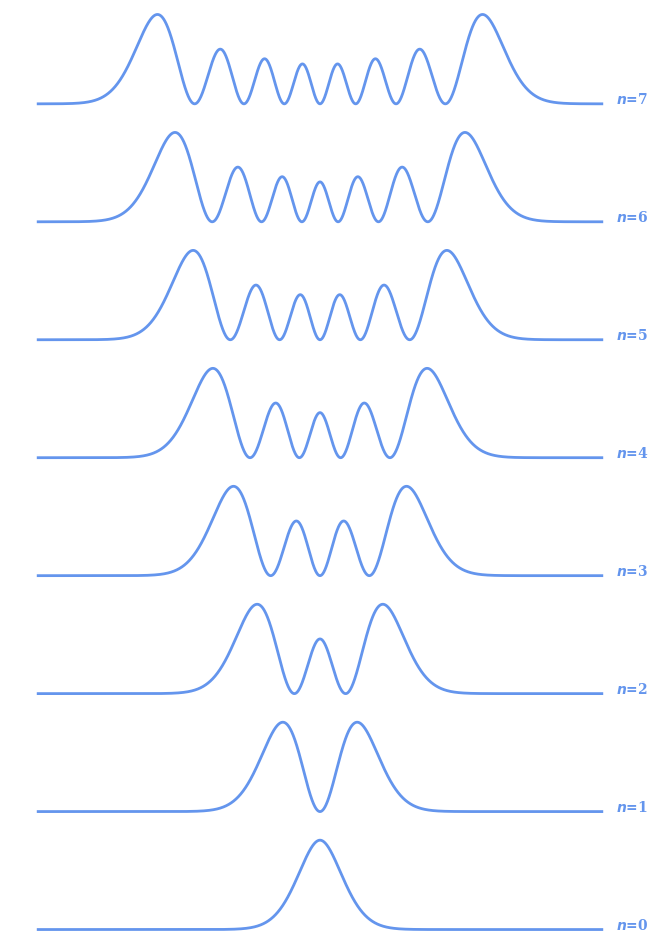

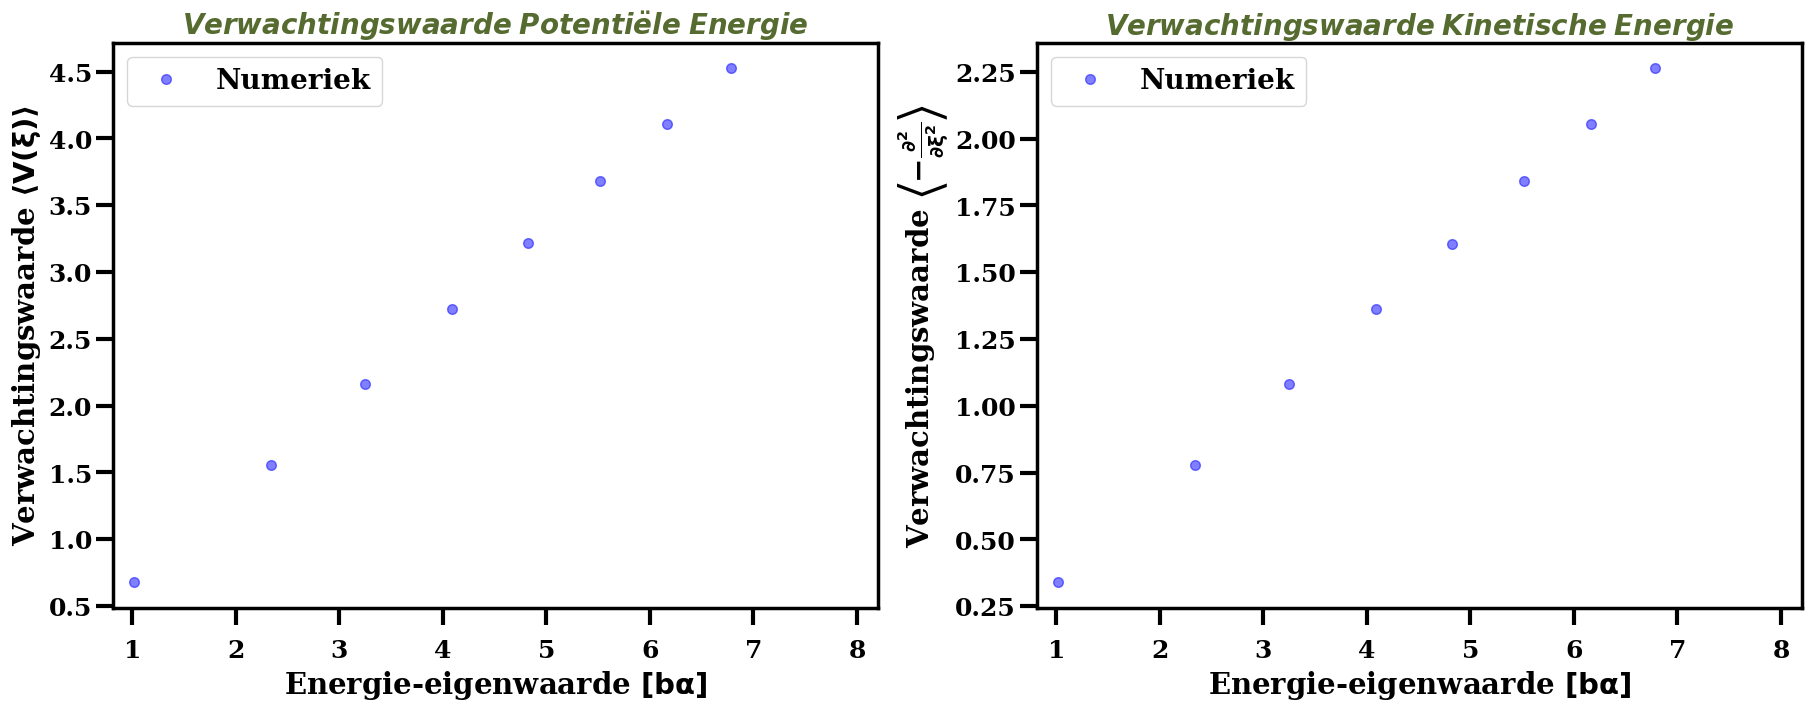

<Figure size 700x700 with 0 Axes>

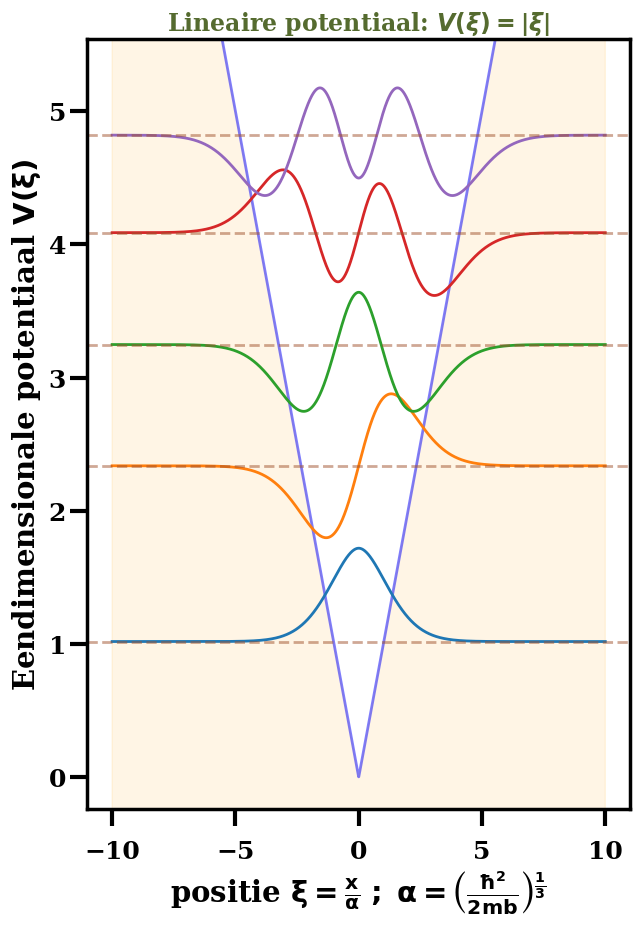

In [10]:
def LinearPot_wavefunctions_plot(xmin = -10, xmax = 10, Nx = 3000, neigs = 8, params = [1.]):
    """
    Running the function LinearPlot_wavefunctions_plot plots the first neigs probability density functions for the
    linear potential!

    Args:
      xmin: lowest x value with a non-negligible value for wavefunction
      xmax: highest x value with a non-negligible value for wavefunction
      Nx: number of grid points
      neigs: expected number of energy eigenvalues
      params: irrelevant parameter for the linear potential

    """
    WatPot=7 # Lennard-Jones potentiaal...
    ScalWav=1.0 # scaling factor for wavefunctions (for the clarity of the plot in the potential)
    EndEner=  8. # bound states of linear potential have a positive energy
    eval_wavefunctions(xmin=xmin, xmax=xmax, Nx=Nx, WatPot=WatPot, params=params, neigs=neigs, findpsi=True, EndEner=EndEner,ScalWav=ScalWav)


LinearPot_wavefunctions_plot()

Toe te voegen als voorbeeld 7: periodische potentialen https://arxiv.org/html/2410.23673v1
